<img style="margin: 0 auto;" src="https://desafiolatam.com/assets/home/logo-academia-bla-790873cdf66b0e681dfbe640ace8a602f5330bec301c409744c358330e823ae3.png">

# Desafio 2 Rendimiento escolar

#### Integrantes
* Catalina Cerda
* José González
* Luis Porras

In [1]:
#Importar librerias
#Manejo de base de datos
import pandas as pd
#Funciones numéricas
import numpy as np
#Librerias de gráficos
import matplotlib.pyplot as plt
import seaborn as sns
#Importe de modulos estadisticos
import scipy.stats as stats
#Analiza los datos perdidos por columna
import missingno

#Importe de statsmodels para la regresión lineal.
import statsmodels.api as sm

#Al importar esta libreria ya no es necesario asignarle valores numéricos a las categorías.
import statsmodels.formula.api as smf

#Ignorar Avisos
import warnings
warnings.filterwarnings("ignore")

#Libreria funciones auxiliares
import herramientas_prueba

#Importe de modelo de regresion lineal y metricas de evaluación
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

#Separación de datos y curva de ROC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve

#libreria para imputar la data
from sklearn.impute import SimpleImputer
#libreria para evaluar los cruces de información
from sklearn.metrics import confusion_matrix

#Ajustar las dimensiones de los gráficos
plt.rcParams["figure.figsize"] = (12,8)

# Hito 1: Sesión Presencial 1, Unidad 7
Completar el punto de Preliminares, así como Aspectos computacionales.

### Desafío 2: Rendimiento escolar
#### Enunciado
Lo contactan de una escuela Portuguesa para generar un modelo que identifique aquellos alumnos
que presentan un bajo desempeño académico, medido en el promedio final del año escolar. Para ello
le envían un archivo con registros sociodemográficos y conductuales de los alumnos dos escuelas
para perfilar a los estudiantes.
De manera adicional la psicopedagoga sugiere inspeccionar una batería de preguntas asociadas a
aspectos ambientales del alumno (de famrel a health ) y ver si éstas se pueden abstraer en
categorías latentes.
### Aspectos adicionales a considerar
* La base de datos presenta una serie de anomalías. En la escuela no tienen buenas prácticas sobre cómo ingresar datos, por lo que existen datos perdidos que están registrados bajo tres categorías: nulidade, sem validade, zero. De manera adicional, hay 3 variables numéricas que se registraron como strings, cuya interpretación en pandas devuelve una estructura de datos genérica. Finalmente, la base está con un encoding distinto al normal y los delimitadores son distintos.
<br>
* Para simplficar el análisis y su posterior inclusión en un modelo predictivo, se sugiere recodificar las variables binarias como 0 y 1. Se recomienda seguir en criterio de asignarle 1 a aquellas categorías minoritarias.
<br>
* El procedimiento también debe aplicarse para aquelas variables nominales con más de 2 categorías siguiendo la misma lógica.
<br>
* En la parte de modelación descriptiva, se deben generar modelos saturados por cada una de las notas registradas en G1 , G2 y G3.
<br>
* Para la parte de modelación predictiva, se debe generar un modelo para predecir las notas en G3.
<br>

### Definición del problema.
* Identifiar cuales son los principales factores que inciden en el rendimiento escolar.

In [2]:
#Cargamos el dataframe y lo asignamos al valor 'df_student'
#Con el argumento sep separamos las celdas de la base de dato que vienen con separado con ' ,'
df_student = pd.read_csv('students.csv', sep='|', encoding='iso-8859-1') 
df_student.head()

,Unnamed: 0,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,0,GP,F,nulidade,U,GT3,A,4,4,at_home,...,4,3,"""4""",1,1,"""3""",6,5,6,6
1,1,GP,F,"""17""",U,GT3,T,1,1,at_home,...,5,3,"""3""",1,1,"""3""",4,5,5,6
2,2,GP,F,"""15""",U,LE3,T,1,1,at_home,...,4,3,"""2""",2,3,"""3""",10,zero,8,10
3,3,GP,F,"""15""",U,GT3,T,4,2,health,...,3,2,"""2""",1,1,"""5""",2,15,14,15
4,4,GP,F,sem validade,U,GT3,T,3,3,other,...,4,3,"""2""",1,2,"""5""",4,6,10,10


Primero dropeamos la columna `Unnamed: 0`

In [3]:
df = df_student.drop(columns = 'Unnamed: 0', axis = 1)
df.head(5)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,nulidade,U,GT3,A,4,4,at_home,teacher,...,4,3,"""4""",1,1,"""3""",6,5,6,6
1,GP,F,"""17""",U,GT3,T,1,1,at_home,other,...,5,3,"""3""",1,1,"""3""",4,5,5,6
2,GP,F,"""15""",U,LE3,T,1,1,at_home,other,...,4,3,"""2""",2,3,"""3""",10,zero,8,10
3,GP,F,"""15""",U,GT3,T,4,2,health,services,...,3,2,"""2""",1,1,"""5""",2,15,14,15
4,GP,F,sem validade,U,GT3,T,3,3,other,other,...,4,3,"""2""",1,2,"""5""",4,6,10,10


Reemplazamos todos los datos mal ingresados (`nulidade`, `sem validade`, `zero`) por `NaN`

In [4]:
df = df.replace('nulidade', np.nan)
df = df.replace('sem validade', np.nan)
df = df.replace('zero',np.nan)
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,NaN,U,GT3,A,4,4,at_home,teacher,...,4,3,"""4""",1,1,"""3""",6,5,6,6
1,GP,F,"""17""",U,GT3,T,1,1,at_home,other,...,5,3,"""3""",1,1,"""3""",4,5,5,6
2,GP,F,"""15""",U,LE3,T,1,1,at_home,other,...,4,3,"""2""",2,3,"""3""",10,NaN,8,10
3,GP,F,"""15""",U,GT3,T,4,2,health,services,...,3,2,"""2""",1,1,"""5""",2,15,14,15
4,GP,F,NaN,U,GT3,T,3,3,other,other,...,4,3,"""2""",1,2,"""5""",4,6,10,10


In [5]:
df['G3'].value_counts('%')

10    0.140306
11    0.119898
0     0.094388
15    0.084184
8     0.081633
12    0.079082
13    0.079082
14    0.068878
9     0.068878
16    0.040816
6     0.038265
18    0.030612
7     0.022959
5     0.017857
17    0.015306
19    0.012755
20    0.002551
4     0.002551
Name: G3, dtype: float64

Reemplazamos los valores `string-numericos` a `Float`

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
school        390 non-null object
sex           392 non-null object
age           391 non-null object
address       393 non-null object
famsize       391 non-null object
Pstatus       389 non-null object
Medu          392 non-null object
Fedu          390 non-null object
Mjob          389 non-null object
Fjob          395 non-null object
reason        391 non-null object
guardian      391 non-null object
traveltime    392 non-null object
studytime     390 non-null object
failures      390 non-null object
schoolsup     387 non-null object
famsup        390 non-null object
paid          394 non-null object
activities    390 non-null object
nursery       389 non-null object
higher        389 non-null object
internet      392 non-null object
romantic      393 non-null object
famrel        390 non-null object
freetime      393 non-null object
goout         390 non-null object
Dalc       

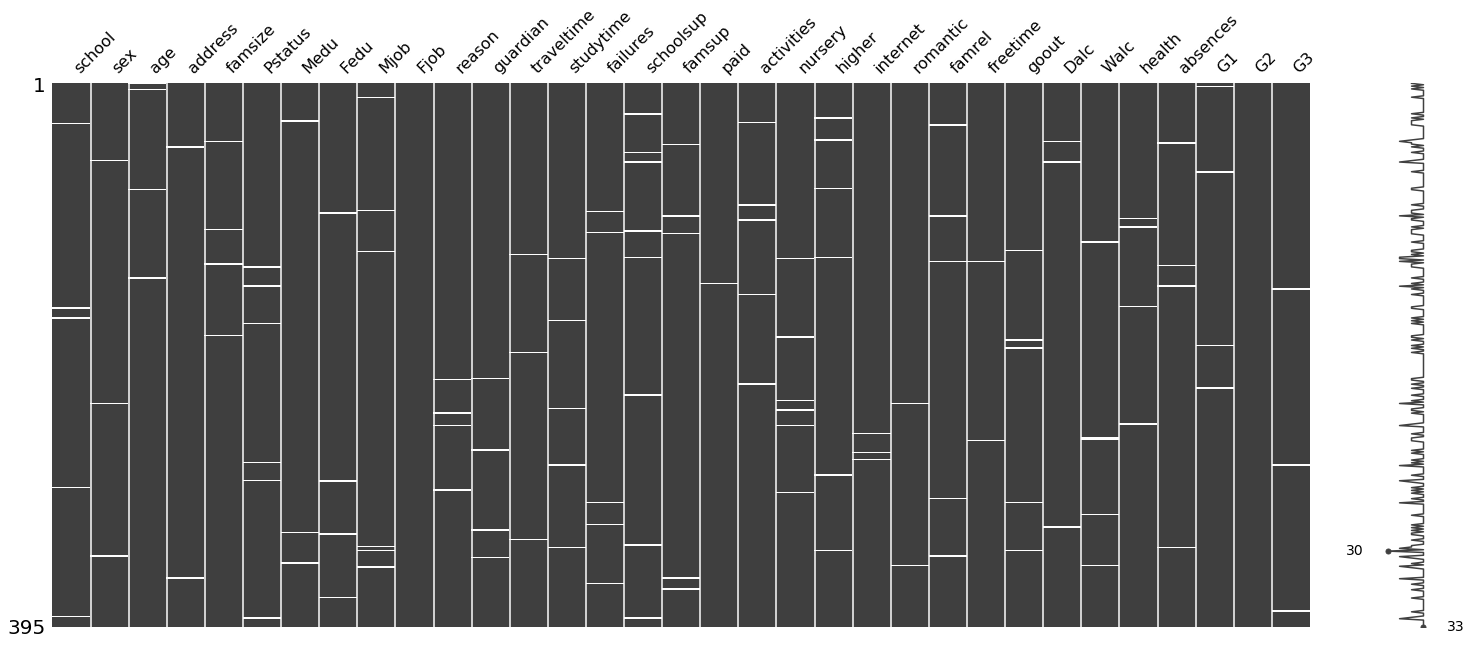

In [7]:
missingno.matrix(df)

In [8]:
df_dropped = df.dropna()

In [9]:
print(f"El porcentaje de datos perdidos si eliminamos todos los N/A es de: {round(len(df_dropped)/len(df)*100, 2)}%")

El porcentaje de datos perdidos si eliminamos todos los N/A es de: 71.9%


Recodificando columna `age` de `String` a `Float`:

In [10]:
df['age'].value_counts()

"16"    101
"17"     98
"15"     82
"18"     81
"19"     24
"20"      3
"22"      1
"21"      1
Name: age, dtype: int64

In [11]:
df['age'] = df['age'].str.replace('\"','')
df['age'].value_counts()

16    101
17     98
15     82
18     81
19     24
20      3
21      1
22      1
Name: age, dtype: int64

In [12]:
df['age'] = df['age'].astype('float')

Recodificando columna `absences` de `String` a `Float`:

In [13]:
df['absences'].value_counts(dropna=False)

0      113
2       64
4       53
6       31
8       22
10      17
14      12
12      11
3        8
7        7
16       7
18       5
5        5
20       4
NaN      4
22       3
15       3
9        3
13       3
11       3
1        3
30       1
17       1
19       1
24       1
26       1
38       1
25       1
28       1
75       1
40       1
21       1
56       1
23       1
54       1
Name: absences, dtype: int64

In [14]:
df['absences'] = df['absences'].astype('float')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
school        390 non-null object
sex           392 non-null object
age           391 non-null float64
address       393 non-null object
famsize       391 non-null object
Pstatus       389 non-null object
Medu          392 non-null object
Fedu          390 non-null object
Mjob          389 non-null object
Fjob          395 non-null object
reason        391 non-null object
guardian      391 non-null object
traveltime    392 non-null object
studytime     390 non-null object
failures      390 non-null object
schoolsup     387 non-null object
famsup        390 non-null object
paid          394 non-null object
activities    390 non-null object
nursery       389 non-null object
higher        389 non-null object
internet      392 non-null object
romantic      393 non-null object
famrel        390 non-null object
freetime      393 non-null object
goout         390 non-null object
Dalc      

In [15]:
df['Medu'] = df['Medu'].astype('float')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
school        390 non-null object
sex           392 non-null object
age           391 non-null float64
address       393 non-null object
famsize       391 non-null object
Pstatus       389 non-null object
Medu          392 non-null float64
Fedu          390 non-null object
Mjob          389 non-null object
Fjob          395 non-null object
reason        391 non-null object
guardian      391 non-null object
traveltime    392 non-null object
studytime     390 non-null object
failures      390 non-null object
schoolsup     387 non-null object
famsup        390 non-null object
paid          394 non-null object
activities    390 non-null object
nursery       389 non-null object
higher        389 non-null object
internet      392 non-null object
romantic      393 non-null object
famrel        390 non-null object
freetime      393 non-null object
goout         390 non-null object
Dalc     

In [16]:
df['Fedu'] = df['Fedu'].astype('float')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
school        390 non-null object
sex           392 non-null object
age           391 non-null float64
address       393 non-null object
famsize       391 non-null object
Pstatus       389 non-null object
Medu          392 non-null float64
Fedu          390 non-null float64
Mjob          389 non-null object
Fjob          395 non-null object
reason        391 non-null object
guardian      391 non-null object
traveltime    392 non-null object
studytime     390 non-null object
failures      390 non-null object
schoolsup     387 non-null object
famsup        390 non-null object
paid          394 non-null object
activities    390 non-null object
nursery       389 non-null object
higher        389 non-null object
internet      392 non-null object
romantic      393 non-null object
famrel        390 non-null object
freetime      393 non-null object
goout         390 non-null object
Dalc    

In [17]:
df['traveltime'] = df['traveltime'].astype('float')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
school        390 non-null object
sex           392 non-null object
age           391 non-null float64
address       393 non-null object
famsize       391 non-null object
Pstatus       389 non-null object
Medu          392 non-null float64
Fedu          390 non-null float64
Mjob          389 non-null object
Fjob          395 non-null object
reason        391 non-null object
guardian      391 non-null object
traveltime    392 non-null float64
studytime     390 non-null object
failures      390 non-null object
schoolsup     387 non-null object
famsup        390 non-null object
paid          394 non-null object
activities    390 non-null object
nursery       389 non-null object
higher        389 non-null object
internet      392 non-null object
romantic      393 non-null object
famrel        390 non-null object
freetime      393 non-null object
goout         390 non-null object
Dalc   

In [18]:
df['studytime'] = df['studytime'].astype('float')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
school        390 non-null object
sex           392 non-null object
age           391 non-null float64
address       393 non-null object
famsize       391 non-null object
Pstatus       389 non-null object
Medu          392 non-null float64
Fedu          390 non-null float64
Mjob          389 non-null object
Fjob          395 non-null object
reason        391 non-null object
guardian      391 non-null object
traveltime    392 non-null float64
studytime     390 non-null float64
failures      390 non-null object
schoolsup     387 non-null object
famsup        390 non-null object
paid          394 non-null object
activities    390 non-null object
nursery       389 non-null object
higher        389 non-null object
internet      392 non-null object
romantic      393 non-null object
famrel        390 non-null object
freetime      393 non-null object
goout         390 non-null object
Dalc  

In [19]:
df['failures'] = df['failures'].astype('float')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
school        390 non-null object
sex           392 non-null object
age           391 non-null float64
address       393 non-null object
famsize       391 non-null object
Pstatus       389 non-null object
Medu          392 non-null float64
Fedu          390 non-null float64
Mjob          389 non-null object
Fjob          395 non-null object
reason        391 non-null object
guardian      391 non-null object
traveltime    392 non-null float64
studytime     390 non-null float64
failures      390 non-null float64
schoolsup     387 non-null object
famsup        390 non-null object
paid          394 non-null object
activities    390 non-null object
nursery       389 non-null object
higher        389 non-null object
internet      392 non-null object
romantic      393 non-null object
famrel        390 non-null object
freetime      393 non-null object
goout         390 non-null object
Dalc 

In [20]:
df['famrel'] = df['famrel'].astype('float')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
school        390 non-null object
sex           392 non-null object
age           391 non-null float64
address       393 non-null object
famsize       391 non-null object
Pstatus       389 non-null object
Medu          392 non-null float64
Fedu          390 non-null float64
Mjob          389 non-null object
Fjob          395 non-null object
reason        391 non-null object
guardian      391 non-null object
traveltime    392 non-null float64
studytime     390 non-null float64
failures      390 non-null float64
schoolsup     387 non-null object
famsup        390 non-null object
paid          394 non-null object
activities    390 non-null object
nursery       389 non-null object
higher        389 non-null object
internet      392 non-null object
romantic      393 non-null object
famrel        390 non-null float64
freetime      393 non-null object
goout         390 non-null object
Dalc

In [21]:
df['freetime'] = df['freetime'].astype('float')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
school        390 non-null object
sex           392 non-null object
age           391 non-null float64
address       393 non-null object
famsize       391 non-null object
Pstatus       389 non-null object
Medu          392 non-null float64
Fedu          390 non-null float64
Mjob          389 non-null object
Fjob          395 non-null object
reason        391 non-null object
guardian      391 non-null object
traveltime    392 non-null float64
studytime     390 non-null float64
failures      390 non-null float64
schoolsup     387 non-null object
famsup        390 non-null object
paid          394 non-null object
activities    390 non-null object
nursery       389 non-null object
higher        389 non-null object
internet      392 non-null object
romantic      393 non-null object
famrel        390 non-null float64
freetime      393 non-null float64
goout         390 non-null object
Dal

In [22]:
df['Dalc'] = df['Dalc'].astype('float')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
school        390 non-null object
sex           392 non-null object
age           391 non-null float64
address       393 non-null object
famsize       391 non-null object
Pstatus       389 non-null object
Medu          392 non-null float64
Fedu          390 non-null float64
Mjob          389 non-null object
Fjob          395 non-null object
reason        391 non-null object
guardian      391 non-null object
traveltime    392 non-null float64
studytime     390 non-null float64
failures      390 non-null float64
schoolsup     387 non-null object
famsup        390 non-null object
paid          394 non-null object
activities    390 non-null object
nursery       389 non-null object
higher        389 non-null object
internet      392 non-null object
romantic      393 non-null object
famrel        390 non-null float64
freetime      393 non-null float64
goout         390 non-null object
Dal

In [23]:
df['Walc'] = df['Walc'].astype('float')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
school        390 non-null object
sex           392 non-null object
age           391 non-null float64
address       393 non-null object
famsize       391 non-null object
Pstatus       389 non-null object
Medu          392 non-null float64
Fedu          390 non-null float64
Mjob          389 non-null object
Fjob          395 non-null object
reason        391 non-null object
guardian      391 non-null object
traveltime    392 non-null float64
studytime     390 non-null float64
failures      390 non-null float64
schoolsup     387 non-null object
famsup        390 non-null object
paid          394 non-null object
activities    390 non-null object
nursery       389 non-null object
higher        389 non-null object
internet      392 non-null object
romantic      393 non-null object
famrel        390 non-null float64
freetime      393 non-null float64
goout         390 non-null object
Dal

In [24]:
df['goout'] = df['goout'].str.replace('\"','')
df['goout'] = df['goout'].astype('float')
df['goout'].value_counts()

3.0    128
2.0    103
4.0     83
5.0     53
1.0     23
Name: goout, dtype: int64

In [25]:
df['health'] = df['health'].str.replace('\"','')
df['health'] = df['health'].astype('float')
df['health'].value_counts()

5.0    145
3.0     91
4.0     66
2.0     45
1.0     44
Name: health, dtype: int64

Recodificando columna `G1` de `String` a `Float`:

In [26]:
df['G1'].value_counts(dropna=False)

10     50
8      41
11     38
7      36
12     35
13     33
9      31
14     30
15     24
6      23
16     22
18      8
17      8
5       7
NaN     4
19      3
4       1
3       1
Name: G1, dtype: int64

In [27]:
df['G1'] = df['G1'].astype('float')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
school        390 non-null object
sex           392 non-null object
age           391 non-null float64
address       393 non-null object
famsize       391 non-null object
Pstatus       389 non-null object
Medu          392 non-null float64
Fedu          390 non-null float64
Mjob          389 non-null object
Fjob          395 non-null object
reason        391 non-null object
guardian      391 non-null object
traveltime    392 non-null float64
studytime     390 non-null float64
failures      390 non-null float64
schoolsup     387 non-null object
famsup        390 non-null object
paid          394 non-null object
activities    390 non-null object
nursery       389 non-null object
higher        389 non-null object
internet      392 non-null object
romantic      393 non-null object
famrel        390 non-null float64
freetime      393 non-null float64
goout         390 non-null float64
Da

Recodificando columna `G2` de `Int` a `Float`:

In [28]:
df['G2'] = df['G2'].astype('float')
#G3 como tiene muchos promedios 0 por la perdida de datos estos seran remplazados por `Nan`
df['G2'] = df['G2'].replace(0, np.nan)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
school        390 non-null object
sex           392 non-null object
age           391 non-null float64
address       393 non-null object
famsize       391 non-null object
Pstatus       389 non-null object
Medu          392 non-null float64
Fedu          390 non-null float64
Mjob          389 non-null object
Fjob          395 non-null object
reason        391 non-null object
guardian      391 non-null object
traveltime    392 non-null float64
studytime     390 non-null float64
failures      390 non-null float64
schoolsup     387 non-null object
famsup        390 non-null object
paid          394 non-null object
activities    390 non-null object
nursery       389 non-null object
higher        389 non-null object
internet      392 non-null object
romantic      393 non-null object
famrel        390 non-null float64
freetime      393 non-null float64
goout         390 non-null float64
Da

Recodificando columna `G3` de `String` a `Float`:

In [29]:
df['G3'] = df['G3'].astype('float')
#G3 como tiene muchos promedios 0 por la perdida de datos estos seran remplazados por `NaN`
df['G3'] = df['G3'].replace(0, np.nan)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
school        390 non-null object
sex           392 non-null object
age           391 non-null float64
address       393 non-null object
famsize       391 non-null object
Pstatus       389 non-null object
Medu          392 non-null float64
Fedu          390 non-null float64
Mjob          389 non-null object
Fjob          395 non-null object
reason        391 non-null object
guardian      391 non-null object
traveltime    392 non-null float64
studytime     390 non-null float64
failures      390 non-null float64
schoolsup     387 non-null object
famsup        390 non-null object
paid          394 non-null object
activities    390 non-null object
nursery       389 non-null object
higher        389 non-null object
internet      392 non-null object
romantic      393 non-null object
famrel        390 non-null float64
freetime      393 non-null float64
goout         390 non-null float64
Da

* Para simplficar el análisis y su posterior inclusión en un modelo predictivo, se sugiere recodificarlas variables binarias como 0 y 1. Se recomienda seguir en criterio de asignarle 1 a aquellas categorías minoritarias.

Reemplazamos las variables  binarias ('school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic')

In [30]:
df = herramientas_prueba.binarize_columns(df, ['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic'])

Analizando Datos de la variable: school
GP    345
MS     45
Name: school, dtype: int64
El valor más frecuente tiene: 345 registros
El valor más frecuente es: GP
Analizando Datos Binarizados de la variable: school
0    345
1     50
Name: b_school, dtype: int64
Analizando Datos de la variable: sex
F    206
M    186
Name: sex, dtype: int64
El valor más frecuente tiene: 206 registros
El valor más frecuente es: F
Analizando Datos Binarizados de la variable: sex
0    206
1    189
Name: b_sex, dtype: int64
Analizando Datos de la variable: address
U    305
R     88
Name: address, dtype: int64
El valor más frecuente tiene: 305 registros
El valor más frecuente es: U
Analizando Datos Binarizados de la variable: address
0    305
1     90
Name: b_address, dtype: int64
Analizando Datos de la variable: famsize
GT3    278
LE3    113
Name: famsize, dtype: int64
El valor más frecuente tiene: 278 registros
El valor más frecuente es: GT3
Analizando Datos Binarizados de la variable: famsize
0    278
1    1

In [31]:
df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3', 'b_school', 'b_sex',
       'b_address', 'b_famsize', 'b_Pstatus', 'b_schoolsup', 'b_famsup',
       'b_paid', 'b_activities', 'b_nursery', 'b_higher', 'b_internet',
       'b_romantic'],
      dtype='object')

* Revisamos los valores que pueden tomar las variables categoricas y le asignamos un valor

In [32]:
df['reason'].value_counts()

course        144
home          108
reputation    103
other          36
Name: reason, dtype: int64

In [33]:
df['guardian'].value_counts()

mother    270
father     89
other      32
Name: guardian, dtype: int64

In [34]:
df['Mjob'].value_counts()

other       138
services    102
at_home      59
teacher      57
health       33
Name: Mjob, dtype: int64

In [35]:
df['Fjob'].value_counts()

other       217
services    111
teacher      29
at_home      20
health       18
Name: Fjob, dtype: int64

In [36]:
df['c_reason'] = df['reason'].replace(['course', 'home', 'reputation', 'other'],
                                           [0, 1, 2, 3])

In [37]:
df['c_guardian'] = df['guardian'].replace(['mother', 'father', 'other'],
                                           [0, 1, 2])

In [38]:
df['c_Mjob'] = df['Mjob'].replace(['other', 'services', 'at_home', 'teacher', 'health'],
                                           [0, 1, 2,3,4])

In [39]:
df['c_Fjob'] = df['Fjob'].replace(['other', 'services', 'teacher', 'at_home', 'health'],
                                           [0, 1, 2,3,4])

In [40]:
df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3', 'b_school', 'b_sex',
       'b_address', 'b_famsize', 'b_Pstatus', 'b_schoolsup', 'b_famsup',
       'b_paid', 'b_activities', 'b_nursery', 'b_higher', 'b_internet',
       'b_romantic', 'c_reason', 'c_guardian', 'c_Mjob', 'c_Fjob'],
      dtype='object')

In [41]:
#Revisamos que todo este en orden
df.sample(5)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,b_paid,b_activities,b_nursery,b_higher,b_internet,b_romantic,c_reason,c_guardian,c_Mjob,c_Fjob
142,GP,F,15.0,U,GT3,T,4.0,4.0,teacher,services,...,1,0,0,0,0,0,0.0,0.0,3.0,1
65,GP,F,16.0,U,LE3,T,4.0,3.0,teacher,services,...,0,0,0,0,0,0,0.0,0.0,3.0,1
337,GP,F,17.0,U,GT3,T,3.0,2.0,other,other,...,1,1,0,0,0,1,1.0,0.0,0.0,0
315,GP,F,19.0,R,GT3,T,2.0,3.0,other,other,...,0,1,0,0,0,1,2.0,2.0,0.0,0
183,GP,F,17.0,U,NaN,T,3.0,3.0,other,other,...,0,0,0,0,0,1,2.0,0.0,0.0,0


# Hito 2
Completar el punto de Descripción.
* Elementos a considerar en éste hito:
    * La inspección visual del vector objetivo. (2 puntos)
    * La inspección visual de las variables. (2 puntos)
    * La inspección de datos perdidos en las variables. (1 punto)
    * De ser necesario, se puede iterar en el proceso de preprocesamiento y recodificación de las variables
* Entregable:  Dos notebooks (uno  por  enunciado) con todos los  puntos detallados einterpretados. De  ser  necesario, un  archivo con  extensión .py  con  todas las  funcionesimplementadas.

# Variable de los vectores objetivos

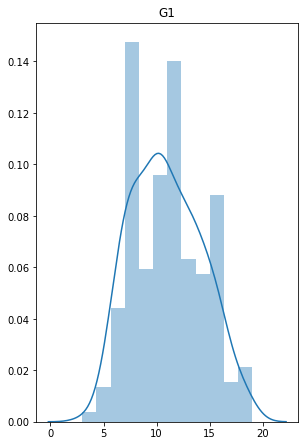

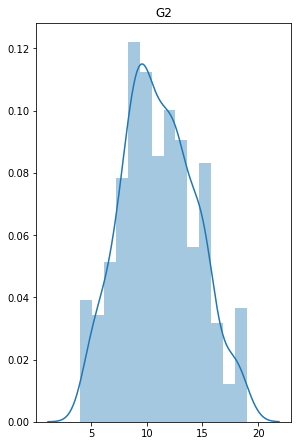

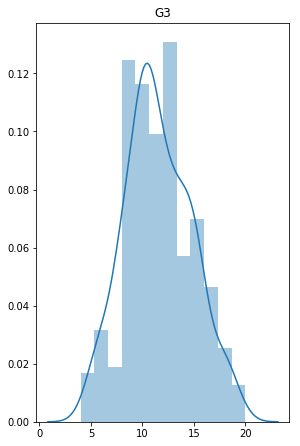

In [42]:
herramientas_prueba.visualize_rows(df.filter(['G1', 'G2', 'G3']))

**conclusiones:** 
Utilizamos los gráficos de histograma porque tenemos que los vectores son variables continuas.
* En el gráfico de `G1` nos muestra que tiene una tendecia a la normal.
* En el gráfico de `G2` nos muestra que el tiene una forma que se que parece a la normal, esto se debe a que hubo muchos 0 en la segunda prueba.
* En el gráfico de `G2` nos muestra que tiene una forma bimodal.

## Variables binarias
**conclusiones:** Para el análisis de variables binariaz usamos histogramas, esto se debe a que las variables binarias son discretas. <br>
También revisamos con 'missigno.matrix(df_escolar)' para ver si eliminar los elementos 'Nan' son significativos, pero revisando la matriz no consideramos que sea significativa la perdida de los valores 'Nan'. 

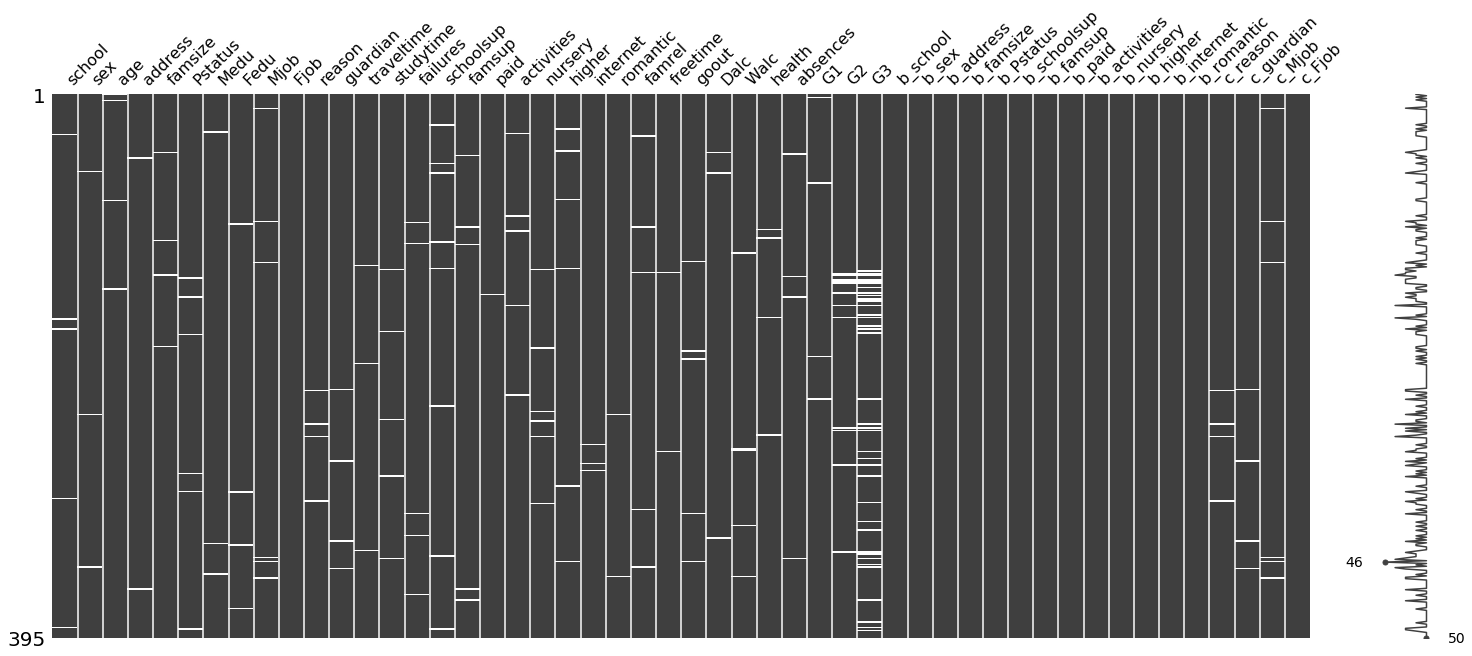

In [43]:
missingno.matrix(df)

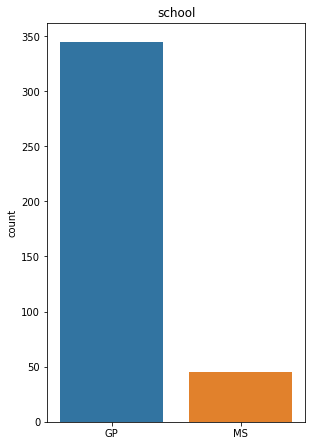

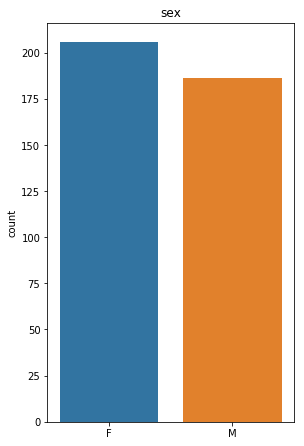

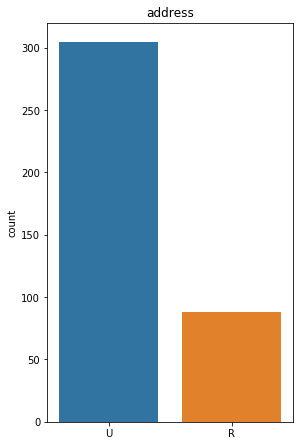

In [44]:
herramientas_prueba.visualize_rows(df.filter(['school', 'sex', 'address']))

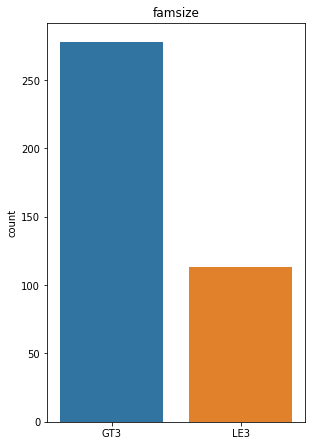

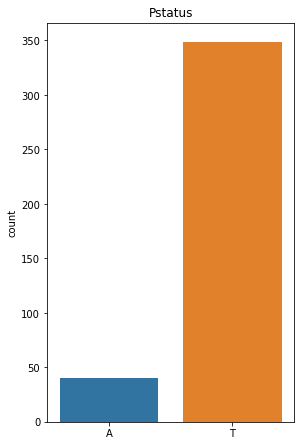

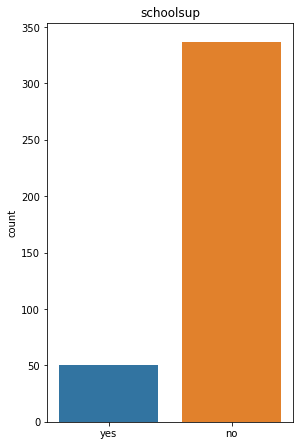

In [45]:
herramientas_prueba.visualize_rows(df.filter(['famsize', 'Pstatus', 'schoolsup']))

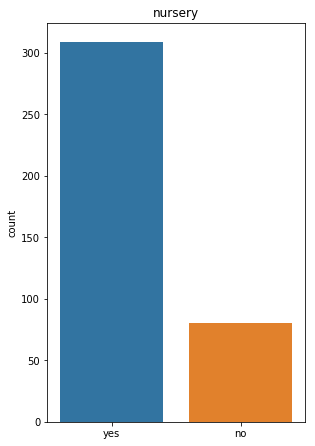

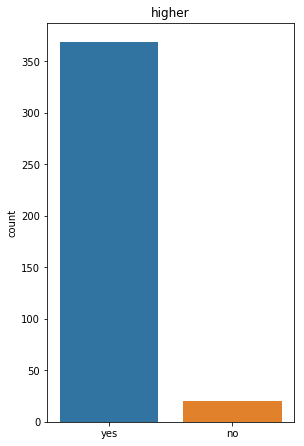

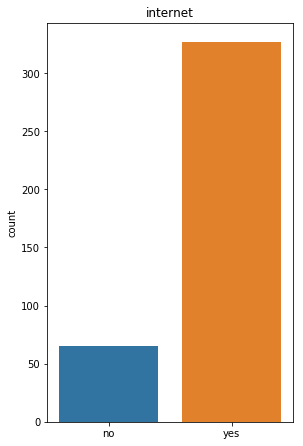

In [46]:
herramientas_prueba.visualize_rows(df.filter(['nursery', 'higher', 'internet']))

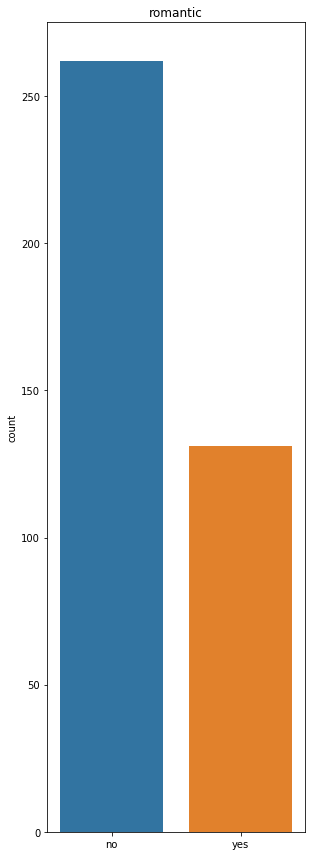

In [47]:
herramientas_prueba.visualize_rows(df.filter(['romantic']))

## Variables categoricas
**conclusiones:** Para el análisis de variables categoricas usamos histogramas, esto se debe a que las variables categoricas pueden tomar valores discretos. <br>
También revisamos con 'missigno.matrix(df_escolar)' para ver si al eliminar los elementos 'NaN' provocamos un cambio significativos, pero revisando la matriz no consideramos que el eliminar los datos 'NaN' por columna sea significativa la perdida de los valores 'NaN'. 

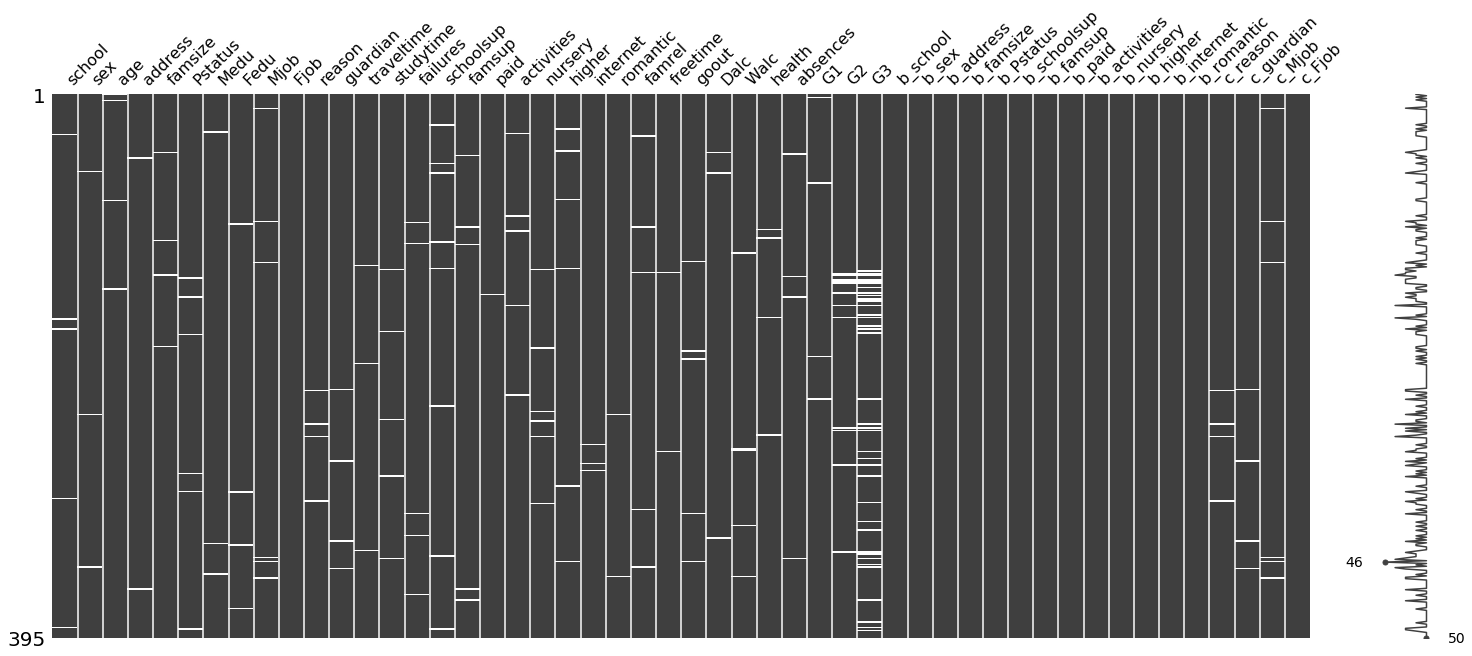

In [48]:
missingno.matrix(df)

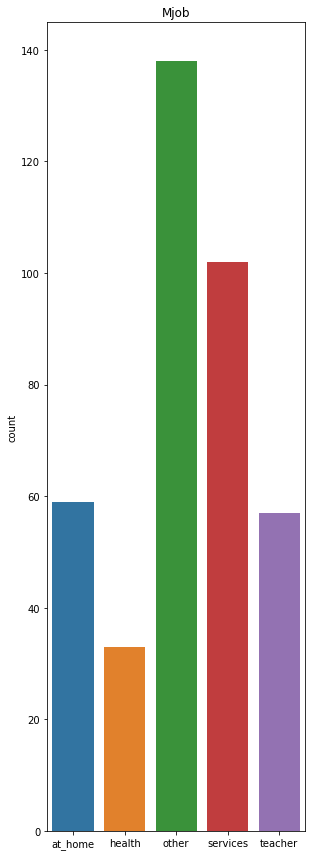

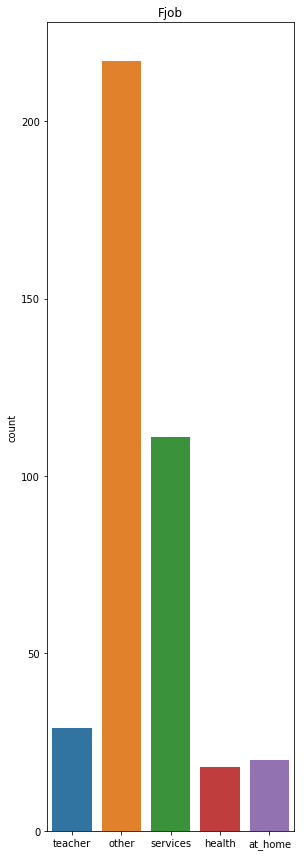

In [49]:
herramientas_prueba.visualize_rows(df.filter(['Mjob', 'Fjob']))

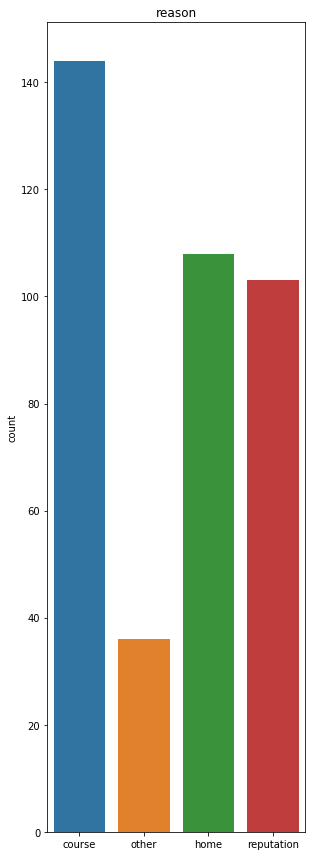

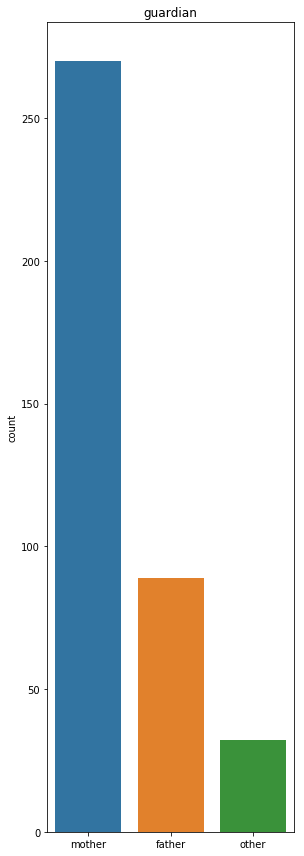

In [50]:
herramientas_prueba.visualize_rows(df.filter(['reason', 'guardian']))

# Hito 3
Completar el punto de **Modelación descriptiva** .
* Elementos a considerar en éste hito:
     * La modelación mediante regresión de ambos problemas. (2 puntos)
     * La interpretación de los principales regresores en cada problema. (2 puntos)
     * La definición de las estrategias de Modelación predictiva. (1 punto)

Preparamos la regresión para variables binariaz, lo primero es graficar con boxplot para ver si hay algina relación en la que el eje Y es nuestra variable dependiente, en este caso 'G3' y las variables independientes iran en el eje X
* Lo primero es comprobar si la variable tiene una forma de normal

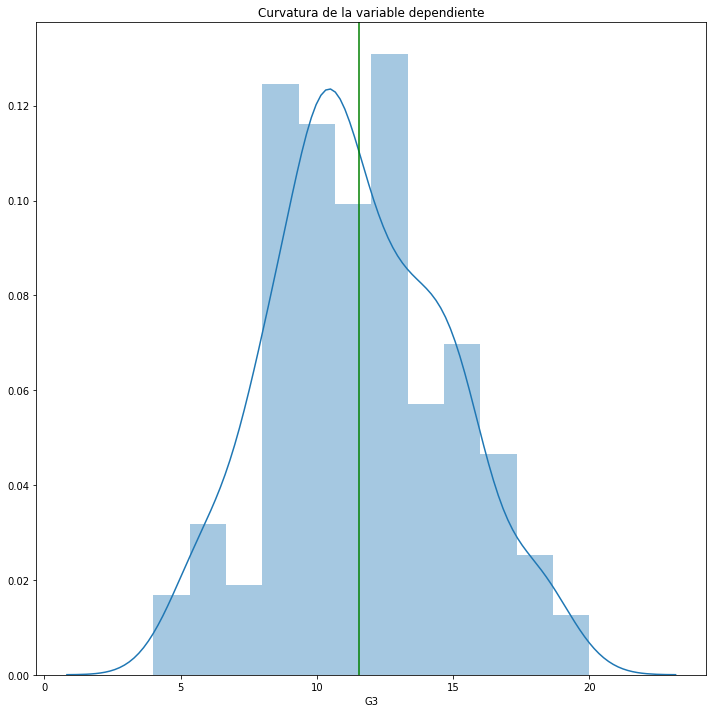

In [51]:
sns.distplot(df['G3'].dropna())
dfm = df['G3'].mean()
plt.title('Curvatura de la variable dependiente')
plt.axvline(dfm, color = 'green')

* Al ver el gráfico se puede concluir que el modelo tiende a la normal, ya que tiene una forma similar a la de una campana y el promedio es casi igual a la moda.
* Para comprobar la normalidad utilizamos los gráficos 'QQ' para ver como se posicionan los datos con respecto a la recta

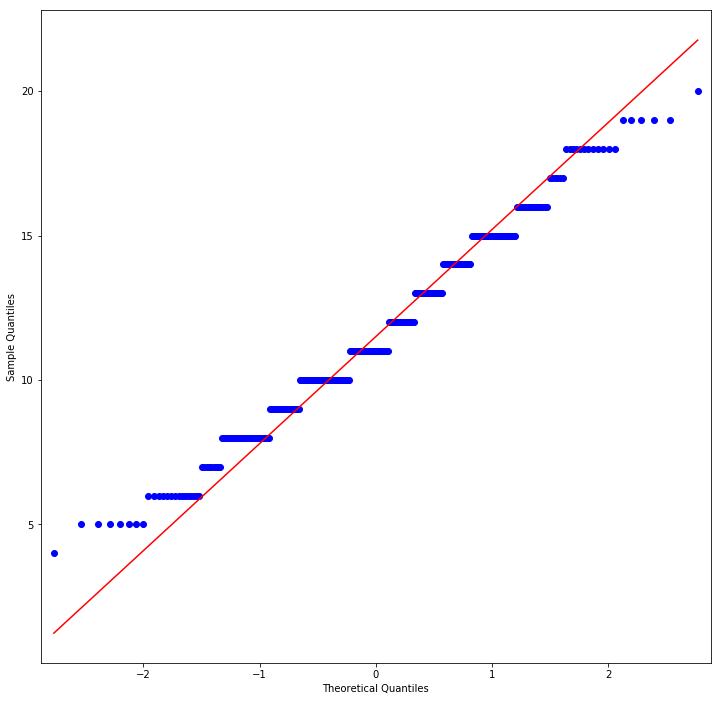

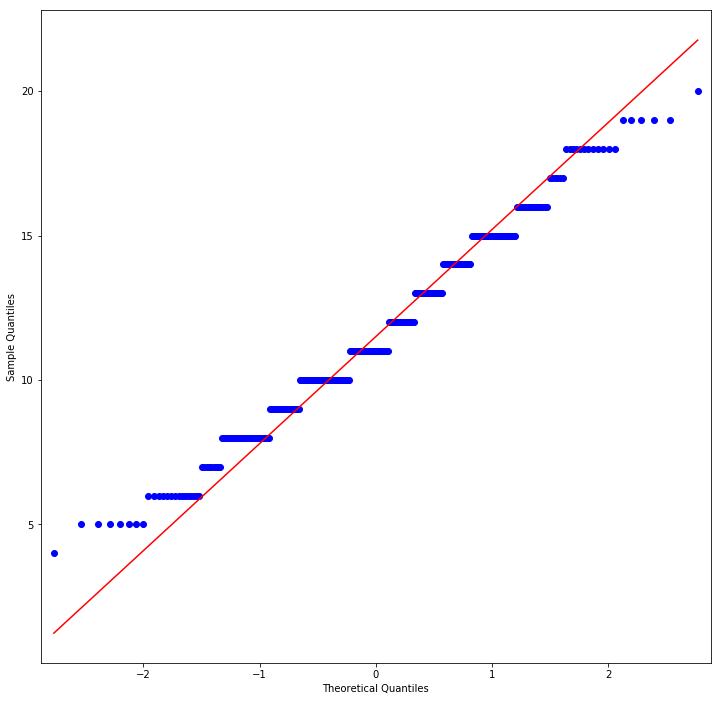

In [52]:
sm.qqplot(df['G3'].dropna(),line = 'q')

**Conclusión:** A partir del los análisis gráficos podemos decir que nuestra variable dependiente `G3` tiende a la normal.

* A continuación realizaremos un análisis descriptivo de la regresión lineal y su respectiva interpretación.

+ Definimos como intervalos de confianza un 90%, por lo tanto todas las variables que tengan un '**P > |t|**' que sea muy mayor a 0,05 seran eliminadas, con excepción de las variables sean mayores a 0,05 pero no mayores a 0,06.

In [53]:
#Asignamos la función de regresión a la variable 'modelo'
modelo = smf.ols('G3 ~ age + Medu + Fedu + traveltime + studytime + failures + famrel + freetime + goout + Dalc + Walc + health + absences + b_school +b_sex + b_address + b_famsize + b_Pstatus + b_schoolsup + b_famsup + b_paid + b_activities + b_nursery + b_higher + b_internet + c_reason + c_guardian + c_Mjob + c_Fjob + G1 + G2', data = df)
#Con la función 'fit' se infieren los parametro del modelo y el intercepto
modelo = modelo.fit()
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     138.6
Date:                Sat, 21 Sep 2019   Prob (F-statistic):          1.81e-144
Time:                        22:50:18   Log-Likelihood:                -345.74
No. Observations:                 295   AIC:                             755.5
Df Residuals:                     263   BIC:                             873.5
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.9517      0.943     -1.009      0.314      -2.809       0.906
age              0.0900      0.051      1.755      0.080      -0.011       0.191
Medu             0.0036      0.067      0.053      0.958      -0.129       0.136
Fedu            -0.0300      0.063     -0.477      0.634      -0.154       0.094
traveltime       0.0630      0.081      0.778      0.437      -0.097       0.223
studytime       -0.0107      0.068     -0.157      0.875      -0.145       0.123
failures        -0.0484      0.091     -0.530      0.596      -0.228       0.131
famrel           0.1602      0.058      2.761      0.006       0.046       0.274
freetime        -0.0650      0.053     -1.235      0.218      -0.169       0.039
goout           -0.0920      0.055     -1.679      0.094      -0.200       0.016
Dalc             0.0257      0.076      0.337      0.737      -0.124       0.176
Walc             0.0057      0.058      0.099      0.921      -0.108       0.119
health          -0.0597      0.037     -1.617      0.107      -0.132       0.013
absences        -0.0134      0.006     -2.060      0.040      -0.026      -0.001
b_school        -0.2391      0.174     -1.375      0.170      -0.582       0.103
b_sex           -0.0319      0.116     -0.274      0.784      -0.261       0.197
b_address       -0.2533      0.135     -1.877      0.062      -0.519       0.012
b_famsize       -0.0740      0.116     -0.638      0.524      -0.302       0.154
b_Pstatus        0.0903      0.163      0.553      0.581      -0.231       0.412
b_schoolsup     -0.1767      0.143     -1.232      0.219      -0.459       0.106
b_famsup        -0.1300      0.113     -1.147      0.252      -0.353       0.093
b_paid          -0.1874      0.109     -1.716      0.087      -0.402       0.028
b_activities     0.0049      0.104      0.047      0.962      -0.200       0.210
b_nursery        0.1412      0.125      1.126      0.261      -0.106       0.388
b_higher         0.0852      0.224      0.381      0.703      -0.355       0.526
b_internet       0.0415      0.138      0.302      0.763      -0.229       0.313
c_reason         0.0307      0.051      0.601      0.549      -0.070       0.131
c_guardian      -0.1197      0.090     -1.324      0.187      -0.298       0.058
c_Mjob           0.0912      0.043      2.103      0.036       0.006       0.176
c_Fjob          -0.0423      0.051     -0.828      0.408      -0.143       0.058
G1               0.1177      0.040      2.976      0.003       0.040       0.196
G2               0.8725      0.040     21.634      0.000       0.793       0.952
==============================================================================
Omnibus:                        0.820   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.664   Jarque-Bera (JB):                0.565
Skew:      

* Como el regresor tiene muchas variables que estan fuera de el intervalo de cofianza se eliminaran las 4 con mayor '**P > |t|**' y se repetira el proceso hasta que todas las variables esten dentro de la zona 

In [54]:
#se elimina 'Medu', 'Walc', 'b_activities'
modelo = smf.ols('G3 ~ age  + Fedu + traveltime + studytime + failures + famrel + freetime + goout + Dalc + health + absences + b_school +b_sex + b_address + b_famsize + b_Pstatus + b_schoolsup + b_famsup + b_paid + b_nursery + b_higher + b_internet + c_reason + c_guardian + c_Mjob + c_Fjob + G1 + G2', data = df)
modelo = modelo.fit()
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     160.4
Date:                Sat, 21 Sep 2019   Prob (F-statistic):          1.01e-152
Time:                        22:50:19   Log-Likelihood:                -354.63
No. Observations:                 303   AIC:                             767.3
Df Residuals:                     274   BIC:                             875.0
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.9303      0.909     -1.024      0.307      -2.719       0.858
age             0.0809      0.049      1.640      0.102      -0.016       0.178
Fedu           -0.0193      0.051     -0.379      0.705      -0.120       0.081
traveltime      0.0729      0.080      0.914      0.361      -0.084       0.230
studytime      -0.0057      0.065     -0.088      0.930      -0.134       0.123
failures       -0.0279      0.088     -0.316      0.752      -0.202       0.146
famrel          0.1697      0.056      3.005      0.003       0.059       0.281
freetime       -0.0635      0.050     -1.260      0.209      -0.163       0.036
goout          -0.0820      0.049     -1.681      0.094      -0.178       0.014
Dalc            0.0374      0.063      0.597      0.551      -0.086       0.161
health         -0.0540      0.036     -1.514      0.131      -0.124       0.016
absences       -0.0135      0.006     -2.133      0.034      -0.026      -0.001
b_school       -0.2184      0.169     -1.290      0.198      -0.552       0.115
b_sex          -0.0384      0.111     -0.345      0.730      -0.258       0.181
b_address      -0.2446      0.131     -1.866      0.063      -0.503       0.013
b_famsize      -0.0789      0.112     -0.702      0.483      -0.300       0.142
b_Pstatus       0.0710      0.158      0.449      0.654      -0.240       0.382
b_schoolsup    -0.1858      0.141     -1.320      0.188      -0.463       0.091
b_famsup       -0.1261      0.111     -1.136      0.257      -0.345       0.092
b_paid         -0.1991      0.107     -1.860      0.064      -0.410       0.012
b_nursery       0.1557      0.121      1.285      0.200      -0.083       0.394
b_higher        0.0725      0.219      0.330      0.741      -0.359       0.504
b_internet      0.0343      0.135      0.254      0.800      -0.232       0.300
c_reason        0.0228      0.050      0.458      0.647      -0.075       0.121
c_guardian     -0.1007      0.087     -1.158      0.248      -0.272       0.070
c_Mjob          0.0870      0.039      2.251      0.025       0.011       0.163
c_Fjob         -0.0445      0.048     -0.922      0.357      -0.139       0.050
G1              0.1206      0.038      3.133      0.002       0.045       0.196
G2              0.8701      0.039     22.226      0.000       0.793       0.947
==============================================================================
Omnibus:                        0.360   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.835   Jarque-Bera (JB):                0.196
Skew:                           0.045   Prob(JB):                        0.907
Kurtosis:                       3.086   Cond. No.                         496.
==============================================================================

Warnings:
[1] Standard Errors assume that the co

In [55]:
#se elimina 'studytime', 'b_Pstatus', 'Fedu' y 'b_activities'
modelo = smf.ols('G3 ~ Medu + studytime + failures + famrel + goout + Walc + health + absences + b_school +b_sex + b_address + b_famsize + b_schoolsup + b_famsup + b_paid + b_nursery + b_higher + b_internet + c_reason + c_Mjob + c_Fjob + G1 + G2', data = df)
modelo = modelo.fit()
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     208.3
Date:                Sat, 21 Sep 2019   Prob (F-statistic):          1.67e-165
Time:                        22:50:20   Log-Likelihood:                -366.95
No. Observations:                 314   AIC:                             781.9
Df Residuals:                     290   BIC:                             871.9
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.3543      0.412      0.859      0.391      -0.457       1.166
Medu           -0.0174      0.051     -0.344      0.731      -0.117       0.082
studytime       0.0121      0.061      0.197      0.844      -0.109       0.133
failures       -0.0529      0.081     -0.649      0.517      -0.213       0.107
famrel          0.1551      0.054      2.869      0.004       0.049       0.261
goout          -0.0794      0.050     -1.595      0.112      -0.177       0.019
Walc            0.0036      0.045      0.079      0.937      -0.085       0.093
health         -0.0595      0.035     -1.699      0.090      -0.129       0.009
absences       -0.0100      0.006     -1.631      0.104      -0.022       0.002
b_school       -0.1309      0.149     -0.879      0.380      -0.424       0.162
b_sex          -0.0341      0.105     -0.324      0.746      -0.241       0.173
b_address      -0.2050      0.120     -1.706      0.089      -0.441       0.031
b_famsize      -0.0160      0.104     -0.153      0.878      -0.221       0.189
b_schoolsup    -0.2337      0.133     -1.763      0.079      -0.495       0.027
b_famsup       -0.1048      0.104     -1.009      0.314      -0.309       0.100
b_paid         -0.1552      0.102     -1.517      0.130      -0.357       0.046
b_nursery       0.1183      0.119      0.995      0.320      -0.116       0.352
b_higher        0.1030      0.216      0.478      0.633      -0.321       0.527
b_internet      0.0746      0.127      0.589      0.556      -0.175       0.324
c_reason        0.0277      0.048      0.583      0.561      -0.066       0.121
c_Mjob          0.0880      0.040      2.181      0.030       0.009       0.167
c_Fjob         -0.0451      0.045     -0.996      0.320      -0.134       0.044
G1              0.1219      0.036      3.428      0.001       0.052       0.192
G2              0.8630      0.037     23.490      0.000       0.791       0.935
==============================================================================
Omnibus:                        1.710   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.425   Jarque-Bera (JB):                1.426
Skew:                           0.126   Prob(JB):                        0.490
Kurtosis:                       3.214   Cond. No.                         177.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [56]:
#se elimina 'Walc', 'famrel', 'b_nursery' y 'c_reason'
modelo = smf.ols('G3 ~ Medu + studytime + failures + goout + health + absences + b_school +b_sex + b_address + b_famsize + b_schoolsup + b_famsup + b_paid + b_higher + b_internet + c_Mjob + c_Fjob +  G1 + G2', data = df)
modelo = modelo.fit()
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     260.0
Date:                Sat, 21 Sep 2019   Prob (F-statistic):          3.76e-176
Time:                        22:50:20   Log-Likelihood:                -385.63
No. Observations:                 326   AIC:                             811.3
Df Residuals:                     306   BIC:                             887.0
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.9022      0.349      2.587      0.010       0.216       1.589
Medu           -0.0183      0.049     -0.371      0.711      -0.115       0.078
studytime       0.0352      0.060      0.586      0.558      -0.083       0.153
failures       -0.0305      0.079     -0.385      0.700      -0.186       0.125
goout          -0.0619      0.043     -1.439      0.151      -0.147       0.023
health         -0.0564      0.034     -1.662      0.097      -0.123       0.010
absences       -0.0103      0.006     -1.715      0.087      -0.022       0.002
b_school       -0.1151      0.148     -0.780      0.436      -0.405       0.175
b_sex          -0.0081      0.101     -0.080      0.936      -0.207       0.191
b_address      -0.1659      0.116     -1.429      0.154      -0.394       0.063
b_famsize      -0.0408      0.100     -0.407      0.684      -0.238       0.157
b_schoolsup    -0.2172      0.131     -1.662      0.098      -0.474       0.040
b_famsup       -0.0980      0.102     -0.959      0.338      -0.299       0.103
b_paid         -0.1723      0.099     -1.737      0.083      -0.368       0.023
b_higher        0.1053      0.215      0.490      0.625      -0.318       0.529
b_internet      0.0561      0.127      0.444      0.658      -0.193       0.305
c_Mjob          0.0833      0.039      2.131      0.034       0.006       0.160
c_Fjob         -0.0529      0.044     -1.211      0.227      -0.139       0.033
G1              0.1153      0.035      3.329      0.001       0.047       0.183
G2              0.8715      0.036     24.251      0.000       0.801       0.942
==============================================================================
Omnibus:                        1.401   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.496   Jarque-Bera (JB):                1.134
Skew:                           0.108   Prob(JB):                        0.567
Kurtosis:                       3.193   Cond. No.                         149.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [57]:
#se elimina 'b_famsize', 'b_higher', 'c_Mjob' y 'b_address'
modelo = smf.ols('G3 ~ Medu + studytime + failures + goout + health + absences + b_school +b_sex + b_schoolsup + b_famsup + b_paid + b_internet + c_Fjob +  G1 + G2 ', data = df)
modelo = modelo.fit()
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     334.9
Date:                Sat, 21 Sep 2019   Prob (F-statistic):          2.12e-183
Time:                        22:50:21   Log-Likelihood:                -392.96
No. Observations:                 331   AIC:                             817.9
Df Residuals:                     315   BIC:                             878.8
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.8801      0.337      2.612      0.009       0.217       1.543
Medu            0.0230      0.045      0.512      0.609      -0.066       0.112
studytime       0.0126      0.059      0.213      0.831      -0.103       0.129
failures       -0.0334      0.078     -0.428      0.669      -0.187       0.120
goout          -0.0564      0.043     -1.323      0.187      -0.140       0.027
health         -0.0557      0.033     -1.664      0.097      -0.122       0.010
absences       -0.0124      0.006     -2.116      0.035      -0.024      -0.001
b_school       -0.1775      0.139     -1.280      0.201      -0.450       0.095
b_sex          -0.0226      0.099     -0.227      0.820      -0.218       0.173
b_schoolsup    -0.2535      0.129     -1.970      0.050      -0.507      -0.000
b_famsup       -0.1023      0.101     -1.017      0.310      -0.300       0.096
b_paid         -0.1532      0.097     -1.582      0.115      -0.344       0.037
b_internet      0.0117      0.123      0.096      0.924      -0.230       0.253
c_Fjob         -0.0269      0.041     -0.654      0.513      -0.108       0.054
G1              0.1241      0.034      3.669      0.000       0.058       0.191
G2              0.8641      0.035     24.643      0.000       0.795       0.933
==============================================================================
Omnibus:                        1.294   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.524   Jarque-Bera (JB):                1.039
Skew:                           0.071   Prob(JB):                        0.595
Kurtosis:                       3.235   Cond. No.                         144.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [58]:
#se elimina 'b_school', 'b_paid', 'health' y 'b_internet'
modelo = smf.ols('G3 ~ Medu + studytime + failures + goout + absences +b_sex + b_schoolsup + b_famsup + c_Fjob ', data = df)
modelo = modelo.fit()
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     10.66
Date:                Sat, 21 Sep 2019   Prob (F-statistic):           1.65e-14
Time:                        22:50:21   Log-Likelihood:                -833.78
No. Observations:                 337   AIC:                             1688.
Df Residuals:                     327   BIC:                             1726.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      10.9529      0.840     13.046      0.000       9.301      12.605
Medu            0.4659      0.155      2.998      0.003       0.160       0.772
studytime       0.4402      0.206      2.134      0.034       0.034       0.846
failures       -1.0502      0.257     -4.090      0.000      -1.555      -0.545
goout          -0.4964      0.149     -3.341      0.001      -0.789      -0.204
absences       -0.0634      0.020     -3.171      0.002      -0.103      -0.024
b_sex           0.6039      0.345      1.750      0.081      -0.075       1.283
b_schoolsup    -1.3684      0.436     -3.136      0.002      -2.227      -0.510
b_famsup        0.7685      0.336      2.288      0.023       0.108       1.429
c_Fjob          0.2335      0.145      1.613      0.108      -0.051       0.518
==============================================================================
Omnibus:                        3.479   Durbin-Watson:                   2.101
Prob(Omnibus):                  0.176   Jarque-Bera (JB):                3.482
Skew:                           0.215   Prob(JB):                        0.175
Kurtosis:                       2.748   Cond. No.                         59.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [59]:
#se elimina 'c_Fjob' y 'b_sex'
modelo = smf.ols('G3 ~ Medu + studytime + failures + goout + absences + b_schoolsup + b_famsup', data = df)
modelo = modelo.fit()
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     12.81
Date:                Sat, 21 Sep 2019   Prob (F-statistic):           1.47e-14
Time:                        22:50:21   Log-Likelihood:                -836.52
No. Observations:                 337   AIC:                             1689.
Df Residuals:                     329   BIC:                             1720.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      11.4728      0.802     14.300      0.000       9.895      13.051
Medu            0.5250      0.154      3.409      0.001       0.222       0.828
studytime       0.3578      0.198      1.811      0.071      -0.031       0.747
failures       -1.0133      0.258     -3.935      0.000      -1.520      -0.507
goout          -0.5031      0.149     -3.371      0.001      -0.797      -0.210
absences       -0.0698      0.020     -3.510      0.001      -0.109      -0.031
b_schoolsup    -1.4244      0.432     -3.301      0.001      -2.273      -0.575
b_famsup        0.8040      0.336      2.393      0.017       0.143       1.465
==============================================================================
Omnibus:                        2.821   Durbin-Watson:                   2.101
Prob(Omnibus):                  0.244   Jarque-Bera (JB):                2.826
Skew:                           0.185   Prob(JB):                        0.243
Kurtosis:                       2.747   Cond. No.                         56.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [60]:
#se elimina 'studytime'
modelo = smf.ols('G3 ~ Medu + failures + goout + absences + b_schoolsup + b_famsup', data = df)
modelo = modelo.fit()
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     14.47
Date:                Sat, 21 Sep 2019   Prob (F-statistic):           1.11e-14
Time:                        22:50:21   Log-Likelihood:                -844.53
No. Observations:                 340   AIC:                             1703.
Df Residuals:                     333   BIC:                             1730.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      12.3364      0.657     18.767      0.000      11.043      13.629
Medu            0.5169      0.153      3.376      0.001       0.216       0.818
failures       -1.0404      0.250     -4.158      0.000      -1.532      -0.548
goout          -0.5231      0.148     -3.525      0.000      -0.815      -0.231
absences       -0.0717      0.020     -3.623      0.000      -0.111      -0.033
b_schoolsup    -1.3982      0.431     -3.246      0.001      -2.246      -0.551
b_famsup        0.7198      0.331      2.176      0.030       0.069       1.370
==============================================================================
Omnibus:                        2.559   Durbin-Watson:                   2.066
Prob(Omnibus):                  0.278   Jarque-Bera (JB):                2.616
Skew:                           0.185   Prob(JB):                        0.270
Kurtosis:                       2.781   Cond. No.                         46.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Conclusiones:** Apartir del modelo generado podemos decir con un 90% confianza la variable dependiente (`G3`) de la muestra se explica en 20,7% por el nivel educacional de la madre (`Medu`),  por el número de clases reprobadas (`failures`), por la salidas con amigos (`goout`), la cantidad de ausencias escolares (`absences`) la escuela del estudiante (`b_schoolsup`) y el apoyo educacional familiar (`b_famsup`), con un error standar de de 0,657 y tiene un intercepto (donde la recta corta al eje $Y$.) que empieza en el punto 12,3364.<br>
Peso de cada vairable ($\beta$) :
* `Medu`: $\beta_{Medu} = -0,5169$
* `failures`: $\beta_{failures} = -1,2382$
* `goout`:$\beta_{goout} = -0,4465$
* `absences`: $\beta_{absences} = -0,0717$
* `b_schoolsup`:$\beta_{bschoolsup} =-1,3982$
* `b_famsup`: $\beta_{bfamsup} = 0,7198$

__Repetimos el proceso con las variables dependientes `G1` y `G2`__
* Comprobamos que nuestra variable `G1` tienda a la normal.

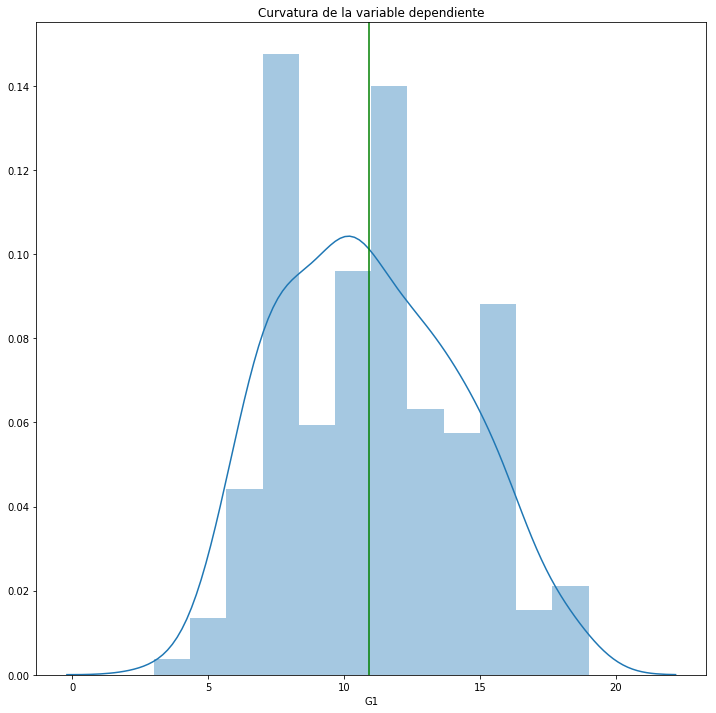

In [61]:
sns.distplot(df['G1'].dropna())
dfm = df['G1'].mean()
plt.title('Curvatura de la variable dependiente')
plt.axvline(dfm, color = 'green')

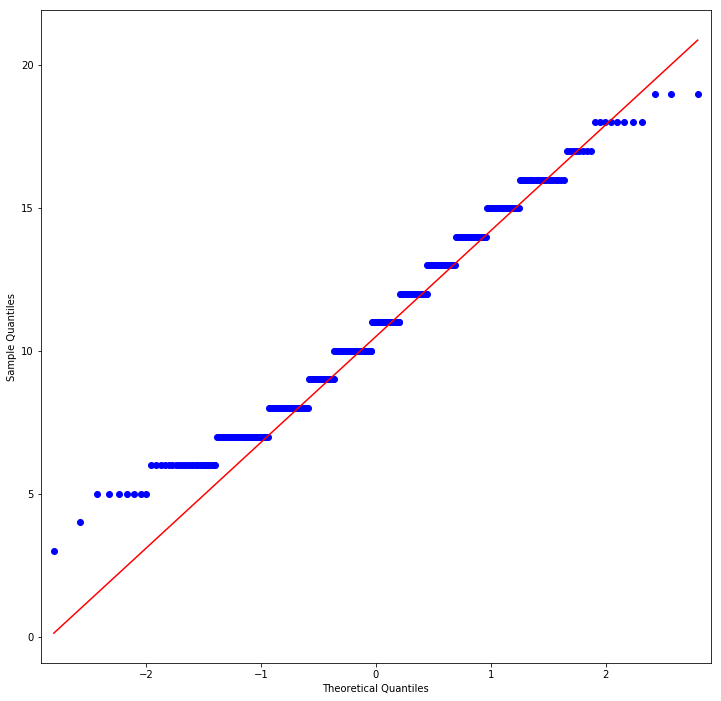

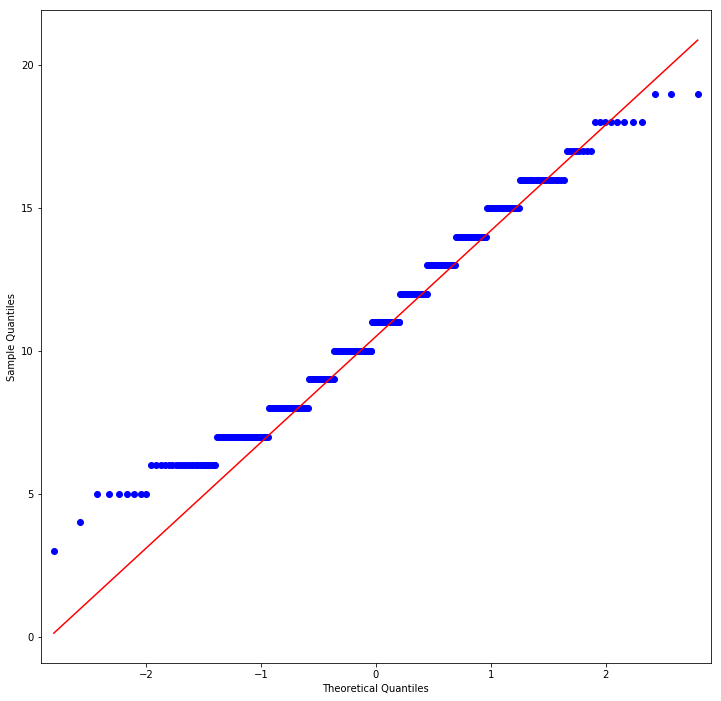

In [62]:
sm.qqplot(df['G1'].dropna(),line = 'q')

**Conclusión:** A partir del los análisis gráficos podemos decir que nuestra variable dependiente `G1` tiende a la normal.

* A continuación realizaremos un análisis descriptivo de la regresión lineal y su respectiva interpretación.

+ Definimos como intervalos de confianza un 90%, por lo tanto todas las variables que tengan un '**P > |t|**' que sea muy mayor a 0,05 seran eliminadas, con excepción de las variables sean mayores a 0,05 pero no mayores a 0,06.

In [63]:
#Asignamos la función de regresión a la variable 'modelo1'
modelo1 = smf.ols('G1 ~ age + Medu + Fedu + traveltime + studytime + failures + famrel + freetime + goout + Dalc + Walc + health + absences + b_school +b_sex + b_address + b_famsize + b_Pstatus + b_schoolsup + b_famsup + b_paid + b_activities + b_nursery + b_higher + b_internet + c_reason + c_guardian + c_Mjob + c_Fjob', data = df)
#Con la función 'fit' se infieren los parametro del modelo y el intercepto
modelo1 = modelo1.fit()
modelo1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G1   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     4.025
Date:                Sat, 21 Sep 2019   Prob (F-statistic):           3.46e-10
Time:                        22:50:23   Log-Likelihood:                -802.48
No. Observations:                 328   AIC:                             1665.
Df Residuals:                     298   BIC:                             1779.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        7.8075      2.946      2.651      0.008       2.011      13.604
age              0.0782      0.162      0.484      0.629      -0.240       0.396
Medu             0.1983      0.228      0.871      0.385      -0.250       0.647
Fedu             0.1918      0.209      0.919      0.359      -0.219       0.603
traveltime      -0.0129      0.259     -0.050      0.960      -0.523       0.497
studytime        0.6069      0.224      2.710      0.007       0.166       1.048
failures        -1.1810      0.252     -4.688      0.000      -1.677      -0.685
famrel           0.0540      0.191      0.283      0.778      -0.322       0.430
freetime         0.3234      0.177      1.824      0.069      -0.026       0.672
goout           -0.5848      0.177     -3.313      0.001      -0.932      -0.237
Dalc            -0.1019      0.260     -0.393      0.695      -0.613       0.409
Walc             0.0813      0.190      0.429      0.668      -0.292       0.455
health          -0.1795      0.125     -1.432      0.153      -0.426       0.067
absences        -0.0005      0.021     -0.024      0.981      -0.042       0.041
b_school        -0.4866      0.569     -0.855      0.393      -1.607       0.633
b_sex            0.5961      0.387      1.539      0.125      -0.166       1.358
b_address       -0.0963      0.449     -0.215      0.830      -0.979       0.786
b_famsize        0.5528      0.392      1.410      0.159      -0.219       1.324
b_Pstatus       -0.0514      0.558     -0.092      0.927      -1.149       1.046
b_schoolsup     -1.2945      0.484     -2.675      0.008      -2.247      -0.342
b_famsup         0.9130      0.377      2.419      0.016       0.170       1.656
b_paid          -0.3631      0.371     -0.978      0.329      -1.094       0.368
b_activities     0.4778      0.340      1.404      0.161      -0.192       1.147
b_nursery        0.0406      0.413      0.098      0.922      -0.772       0.853
b_higher        -1.4640      0.696     -2.102      0.036      -2.834      -0.094
b_internet      -0.1062      0.458     -0.232      0.817      -1.007       0.795
c_reason         0.1807      0.173      1.046      0.297      -0.159       0.521
c_guardian       0.1039      0.292      0.355      0.723      -0.472       0.680
c_Mjob           0.1418      0.144      0.982      0.327      -0.142       0.426
c_Fjob           0.2916      0.173      1.684      0.093      -0.049       0.632
==============================================================================
Omnibus:                        6.630   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.036   Jarque-Bera (JB):                5.510
Skew:                           0.230   Prob(JB):                       0.0636
Kurtosis:                       2.563   Cond. No.                         367.
===============

In [64]:
#Se elimina 'traveltime', 'absences', 'b_Pstatus' y 'b_address'
modelo1 = smf.ols('G1 ~ age + Medu + Fedu + studytime + failures + famrel + freetime + goout + Dalc + Walc + health + b_school + b_sex + b_famsize + b_schoolsup + b_famsup + b_paid + b_activities + b_nursery + b_higher + b_internet + c_reason + c_guardian + c_Mjob + c_Fjob', data = df)
modelo1 = modelo1.fit()
modelo1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G1   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     4.834
Date:                Sat, 21 Sep 2019   Prob (F-statistic):           6.96e-12
Time:                        22:50:24   Log-Likelihood:                -815.42
No. Observations:                 334   AIC:                             1683.
Df Residuals:                     308   BIC:                             1782.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        7.5147      2.782      2.702      0.007       2.041      12.988
age              0.0905      0.154      0.586      0.558      -0.213       0.394
Medu             0.2053      0.213      0.964      0.336      -0.214       0.624
Fedu             0.2095      0.200      1.047      0.296      -0.184       0.603
studytime        0.6225      0.215      2.889      0.004       0.199       1.046
failures        -1.1779      0.247     -4.778      0.000      -1.663      -0.693
famrel           0.0299      0.187      0.160      0.873      -0.337       0.397
freetime         0.3123      0.173      1.802      0.073      -0.029       0.653
goout           -0.5746      0.171     -3.362      0.001      -0.911      -0.238
Dalc            -0.1061      0.254     -0.417      0.677      -0.606       0.394
Walc             0.0830      0.184      0.452      0.652      -0.278       0.444
health          -0.1655      0.121     -1.363      0.174      -0.404       0.073
b_school        -0.5277      0.526     -1.002      0.317      -1.564       0.508
b_sex            0.5772      0.373      1.549      0.122      -0.156       1.310
b_famsize        0.5990      0.367      1.630      0.104      -0.124       1.322
b_schoolsup     -1.3499      0.472     -2.862      0.004      -2.278      -0.422
b_famsup         0.9223      0.366      2.522      0.012       0.203       1.642
b_paid          -0.3667      0.361     -1.016      0.310      -1.077       0.343
b_activities     0.4359      0.329      1.324      0.187      -0.212       1.084
b_nursery        0.0638      0.402      0.159      0.874      -0.726       0.854
b_higher        -1.4446      0.685     -2.109      0.036      -2.793      -0.097
b_internet      -0.1107      0.439     -0.252      0.801      -0.975       0.754
c_reason         0.1821      0.167      1.089      0.277      -0.147       0.511
c_guardian       0.1068      0.281      0.380      0.704      -0.446       0.659
c_Mjob           0.1406      0.139      1.014      0.311      -0.132       0.413
c_Fjob           0.2945      0.169      1.746      0.082      -0.037       0.626
==============================================================================
Omnibus:                        6.341   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.042   Jarque-Bera (JB):                5.473
Skew:                           0.237   Prob(JB):                       0.0648
Kurtosis:                       2.588   Cond. No.                         334.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [65]:
#Se elimina 'famrel', 'b_internet', 'c_guardian' y 'Dalc'
modelo1 = smf.ols('G1 ~ age + Medu + Fedu + studytime + failures + freetime + goout + Walc + health + b_school + b_sex + b_famsize + b_schoolsup + b_famsup + b_paid + b_activities + b_nursery + b_higher + c_reason + c_Mjob + c_Fjob', data = df)
modelo1 = modelo1.fit()
modelo1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G1   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     5.845
Date:                Sat, 21 Sep 2019   Prob (F-statistic):           1.64e-13
Time:                        22:50:24   Log-Likelihood:                -843.92
No. Observations:                 345   AIC:                             1732.
Df Residuals:                     323   BIC:                             1816.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        8.0828      2.644      3.057      0.002       2.881      13.284
age              0.0644      0.146      0.440      0.660      -0.223       0.352
Medu             0.1604      0.202      0.795      0.427      -0.236       0.557
Fedu             0.2307      0.194      1.189      0.235      -0.151       0.612
studytime        0.6578      0.211      3.124      0.002       0.243       1.072
failures        -1.1853      0.240     -4.929      0.000      -1.658      -0.712
freetime         0.2904      0.168      1.733      0.084      -0.039       0.620
goout           -0.4841      0.164     -2.948      0.003      -0.807      -0.161
Walc            -0.0240      0.148     -0.161      0.872      -0.316       0.268
health          -0.1716      0.119     -1.440      0.151      -0.406       0.063
b_school        -0.4457      0.515     -0.866      0.387      -1.458       0.567
b_sex            0.6200      0.362      1.713      0.088      -0.092       1.332
b_famsize        0.6351      0.355      1.788      0.075      -0.064       1.334
b_schoolsup     -1.3339      0.459     -2.908      0.004      -2.236      -0.431
b_famsup         0.8745      0.356      2.454      0.015       0.173       1.576
b_paid          -0.4991      0.350     -1.427      0.154      -1.187       0.189
b_activities     0.3187      0.322      0.989      0.323      -0.315       0.952
b_nursery        0.0630      0.387      0.163      0.871      -0.699       0.825
b_higher        -1.4199      0.675     -2.105      0.036      -2.747      -0.093
c_reason         0.1462      0.163      0.897      0.370      -0.174       0.467
c_Mjob           0.1397      0.134      1.046      0.296      -0.123       0.402
c_Fjob           0.3203      0.161      1.995      0.047       0.004       0.636
==============================================================================
Omnibus:                        7.583   Durbin-Watson:                   2.097
Prob(Omnibus):                  0.023   Jarque-Bera (JB):                6.564
Skew:                           0.264   Prob(JB):                       0.0376
Kurtosis:                       2.577   Cond. No.                         316.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [66]:
#Se elimina 'age', 'b_nursery', 'Walc' y 'Medu'
modelo1 = smf.ols('G1 ~  Fedu + studytime + failures + freetime + goout + health + b_school + b_sex + b_famsize + b_schoolsup + b_famsup + b_paid + b_activities + b_higher + c_reason + c_Mjob + c_Fjob', data = df)
modelo1 = modelo1.fit()
modelo1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G1   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     7.275
Date:                Sat, 21 Sep 2019   Prob (F-statistic):           3.27e-15
Time:                        22:50:25   Log-Likelihood:                -875.73
No. Observations:                 357   AIC:                             1787.
Df Residuals:                     339   BIC:                             1857.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        9.4027      1.088      8.640      0.000       7.262      11.543
Fedu             0.2584      0.158      1.634      0.103      -0.053       0.570
studytime        0.6608      0.203      3.262      0.001       0.262       1.059
failures        -1.1974      0.229     -5.220      0.000      -1.649      -0.746
freetime         0.2458      0.165      1.494      0.136      -0.078       0.570
goout           -0.4199      0.145     -2.891      0.004      -0.706      -0.134
health          -0.1721      0.115     -1.493      0.136      -0.399       0.055
b_school        -0.4058      0.470     -0.863      0.389      -1.331       0.519
b_sex            0.7336      0.342      2.145      0.033       0.061       1.406
b_famsize        0.5563      0.344      1.616      0.107      -0.121       1.233
b_schoolsup     -1.4981      0.442     -3.393      0.001      -2.367      -0.630
b_famsup         0.8700      0.348      2.503      0.013       0.186       1.554
b_paid          -0.4874      0.342     -1.425      0.155      -1.160       0.186
b_activities     0.1840      0.317      0.581      0.561      -0.439       0.807
b_higher        -1.4621      0.670     -2.184      0.030      -2.779      -0.145
c_reason         0.1905      0.160      1.194      0.233      -0.123       0.504
c_Mjob           0.1889      0.124      1.520      0.129      -0.056       0.433
c_Fjob           0.2907      0.156      1.867      0.063      -0.016       0.597
==============================================================================
Omnibus:                        7.731   Durbin-Watson:                   2.125
Prob(Omnibus):                  0.021   Jarque-Bera (JB):                6.581
Skew:                           0.254   Prob(JB):                       0.0372
Kurtosis:                       2.571   Cond. No.                         51.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [67]:
#Se elimina 'b_activities', 'c_reason', 'b_school' y 'b_paid'
modelo1 = smf.ols('G1 ~  Fedu + studytime + failures + freetime + goout + health + b_sex + b_famsize + b_schoolsup + b_famsup + b_higher + c_Mjob + c_Fjob', data = df)
modelo1 = modelo1.fit()
modelo1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G1   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     9.269
Date:                Sat, 21 Sep 2019   Prob (F-statistic):           1.75e-16
Time:                        22:50:25   Log-Likelihood:                -890.35
No. Observations:                 361   AIC:                             1809.
Df Residuals:                     347   BIC:                             1863.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       9.6029      0.997      9.636      0.000       7.643      11.563
Fedu            0.2473      0.159      1.557      0.120      -0.065       0.560
studytime       0.6080      0.201      3.019      0.003       0.212       1.004
failures       -1.2287      0.228     -5.388      0.000      -1.677      -0.780
freetime        0.2570      0.164      1.568      0.118      -0.065       0.579
goout          -0.4381      0.146     -3.008      0.003      -0.725      -0.152
health         -0.1853      0.114     -1.624      0.105      -0.410       0.039
b_sex           0.6737      0.341      1.977      0.049       0.004       1.344
b_famsize       0.4604      0.343      1.344      0.180      -0.214       1.134
b_schoolsup    -1.4434      0.438     -3.298      0.001      -2.304      -0.583
b_famsup        0.9854      0.330      2.989      0.003       0.337       1.634
b_higher       -1.4310      0.655     -2.184      0.030      -2.720      -0.142
c_Mjob          0.2064      0.122      1.686      0.093      -0.034       0.447
c_Fjob          0.2984      0.155      1.926      0.055      -0.006       0.603
==============================================================================
Omnibus:                        6.377   Durbin-Watson:                   2.111
Prob(Omnibus):                  0.041   Jarque-Bera (JB):                5.452
Skew:                           0.222   Prob(JB):                       0.0655
Kurtosis:                       2.593   Cond. No.                         46.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [68]:
#Se elimina 'Fedu', 'freetime', 'health' y 'b_famsize'
modelo1 = smf.ols('G1 ~  studytime + failures + goout + b_sex + b_schoolsup + b_famsup + b_higher + c_Mjob + c_Fjob', data = df)
modelo1 = modelo1.fit()
modelo1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G1   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     13.01
Date:                Sat, 21 Sep 2019   Prob (F-statistic):           5.07e-18
Time:                        22:50:25   Log-Likelihood:                -923.22
No. Observations:                 372   AIC:                             1866.
Df Residuals:                     362   BIC:                             1906.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      10.1703      0.714     14.234      0.000       8.765      11.575
studytime       0.5360      0.196      2.737      0.007       0.151       0.921
failures       -1.3528      0.221     -6.120      0.000      -1.787      -0.918
goout          -0.3215      0.137     -2.340      0.020      -0.592      -0.051
b_sex           0.8598      0.327      2.631      0.009       0.217       1.502
b_schoolsup    -1.4206      0.440     -3.227      0.001      -2.287      -0.555
b_famsup        0.8916      0.321      2.777      0.006       0.260       1.523
b_higher       -1.5019      0.650     -2.312      0.021      -2.779      -0.225
c_Mjob          0.2784      0.120      2.312      0.021       0.042       0.515
c_Fjob          0.3496      0.148      2.357      0.019       0.058       0.641
==============================================================================
Omnibus:                        7.342   Durbin-Watson:                   2.108
Prob(Omnibus):                  0.025   Jarque-Bera (JB):                6.253
Skew:                           0.239   Prob(JB):                       0.0439
Kurtosis:                       2.582   Cond. No.                         21.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Conclusiones:** Apartir del modelo generado podemos decir con un 90% confianza la variable dependiente (`G1`) de la muestra se explica en 24,4% por el tiempo de estudio (`studytime`), por el número de clases reprobadas (`failures`), por la salidas con amigos (`goout`), el sexo del estudiante (`b_sex`) la escuela del estudiante (`b_schoolsup`), el apoyo educacional familiar (`b_famsup`), el deseo de seguir con estudios superiores (`b_higher`), la ocupación de la madre (`c_Mjob`) y la ocupación del padre (`c_Fjob`) con un error standar de de 0,714 y tiene un intercepto (donde la recta corta al eje $Y$.) que empieza en el punto 10,1703.<br>
Peso de cada vairable ($\beta$) :
* `studytime`: $\beta_{studytime} = 0,5360$
* `failures`: $\beta_{failures} = -1,2382$
* `goout`:$\beta_{goout} = -0,3215$
* `b_sex`: $\beta_{bsex} = 0,8598$
* `b_schoolsup`:$\beta_{bschoolsup} =-1,4206$
* `b_famsup`: $\beta_{bfamsup} = 0,8916$
* `b_higher`: $\beta_{bhigher} = -1,5019$
* `c_Mjob`: $\beta_{c_Mjob} = 0,2784$
* `c_Fjob`: $\beta_{c_Fjob} = 0,3496$

**Repetimos el mismo proceso para `G2`**

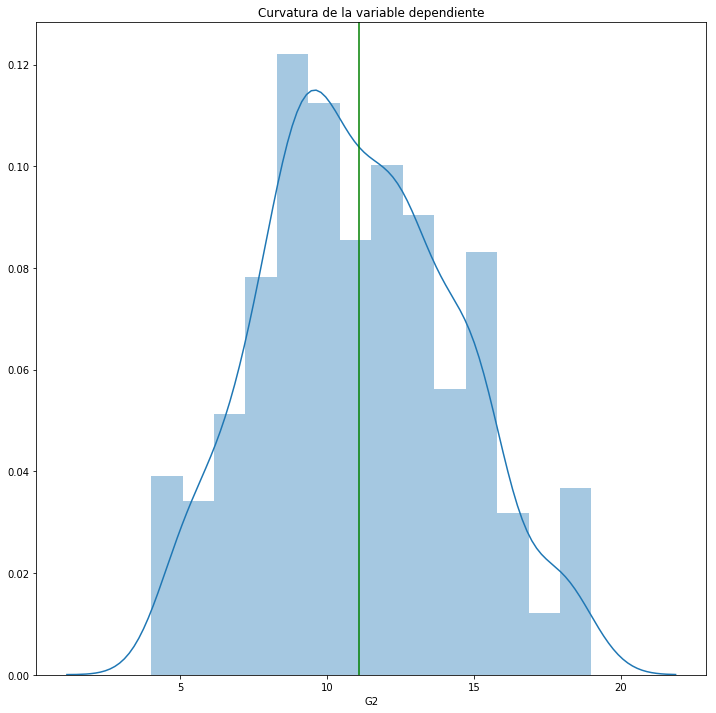

In [69]:
sns.distplot(df['G2'].dropna())
dfm = df['G2'].mean()
plt.title('Curvatura de la variable dependiente')
plt.axvline(dfm, color = 'green')

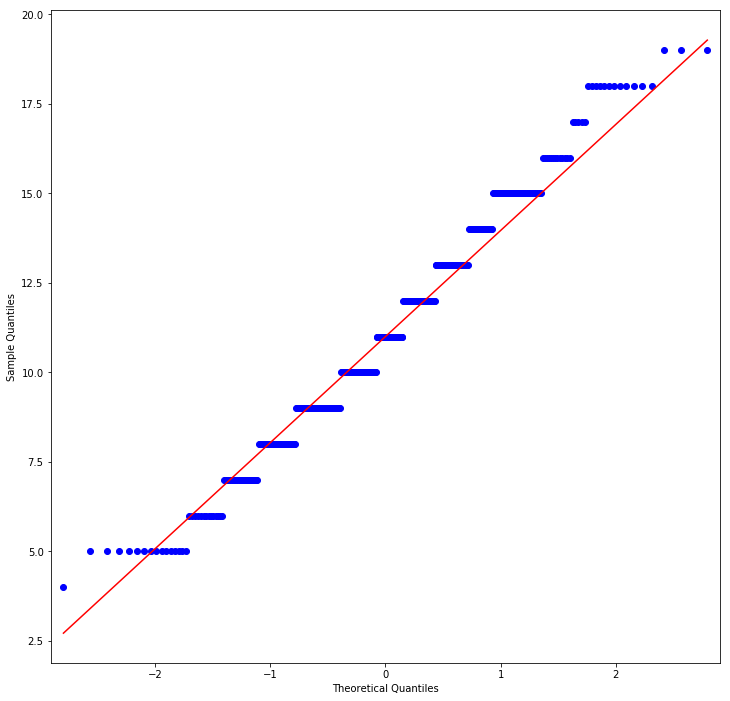

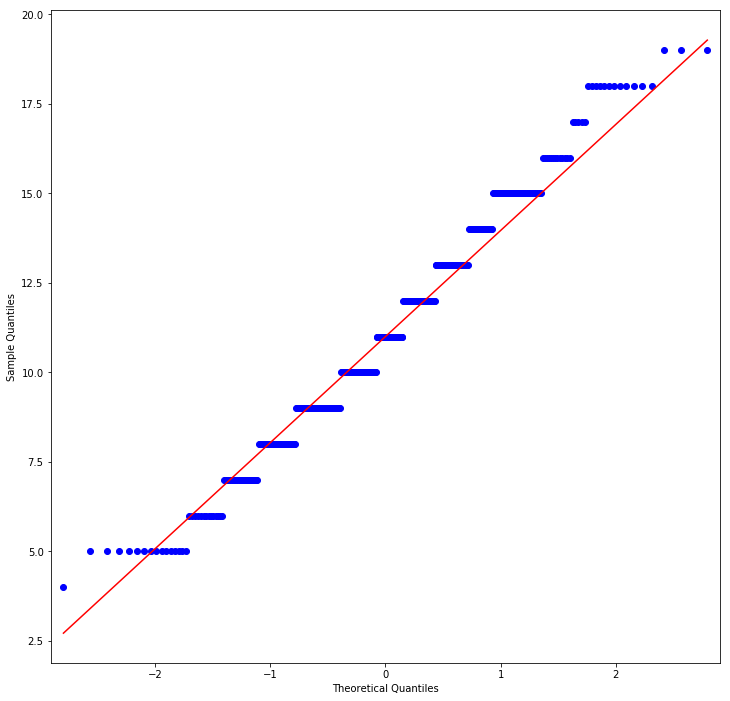

In [70]:
sm.qqplot(df['G2'].dropna(),line = 'q')

**Conclusión:** A partir del los análisis gráficos podemos decir que nuestra variable dependiente `G1` tiende a la normal.

* A continuación realizaremos un análisis descriptivo de la regresión lineal y su respectiva interpretación.

In [71]:
#Asignamos la función de regresión a la variable 'modelo1'
modelo2 = smf.ols('G2 ~ age + Medu + Fedu + traveltime + studytime + failures + famrel + freetime + goout + Dalc + Walc + health + absences + b_school +b_sex + b_address + b_famsize + b_Pstatus + b_schoolsup + b_famsup + b_paid + b_activities + b_nursery + b_higher + b_internet + c_reason + c_guardian + c_Mjob + c_Fjob', data = df)
#Con la función 'fit' se infieren los parametro del modelo y el intercepto
modelo2 = modelo2.fit()
modelo2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G2   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     3.902
Date:                Sat, 21 Sep 2019   Prob (F-statistic):           1.04e-09
Time:                        22:50:28   Log-Likelihood:                -778.04
No. Observations:                 320   AIC:                             1616.
Df Residuals:                     290   BIC:                             1729.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       12.9480      2.969      4.362      0.000       7.105      18.790
age             -0.2045      0.163     -1.254      0.211      -0.525       0.116
Medu             0.4391      0.222      1.976      0.049       0.002       0.876
Fedu             0.0284      0.210      0.136      0.892      -0.384       0.441
traveltime       0.0408      0.266      0.153      0.878      -0.483       0.564
studytime        0.4213      0.225      1.876      0.062      -0.021       0.863
failures        -1.1534      0.255     -4.532      0.000      -1.654      -0.653
famrel           0.1197      0.190      0.631      0.528      -0.253       0.493
freetime         0.1927      0.176      1.097      0.274      -0.153       0.539
goout           -0.4727      0.178     -2.654      0.008      -0.823      -0.122
Dalc            -0.1014      0.256     -0.396      0.693      -0.606       0.403
Walc             0.0399      0.188      0.213      0.832      -0.329       0.409
health          -0.1562      0.124     -1.263      0.207      -0.399       0.087
absences        -0.0360      0.021     -1.698      0.091      -0.078       0.006
b_school        -0.5715      0.569     -1.004      0.316      -1.692       0.549
b_sex            0.5476      0.388      1.412      0.159      -0.215       1.311
b_address       -0.3155      0.450     -0.702      0.483      -1.200       0.569
b_famsize        0.5932      0.387      1.533      0.126      -0.169       1.355
b_Pstatus        0.2900      0.559      0.519      0.604      -0.810       1.390
b_schoolsup     -1.2032      0.476     -2.529      0.012      -2.140      -0.267
b_famsup         0.7962      0.376      2.120      0.035       0.057       1.536
b_paid          -0.1705      0.368     -0.463      0.644      -0.895       0.554
b_activities     0.4304      0.344      1.253      0.211      -0.246       1.107
b_nursery        0.1546      0.416      0.371      0.711      -0.665       0.974
b_higher        -1.0400      0.714     -1.456      0.147      -2.446       0.366
b_internet      -0.4760      0.457     -1.042      0.298      -1.375       0.423
c_reason         0.1035      0.171      0.606      0.545      -0.233       0.439
c_guardian       0.2611      0.294      0.889      0.375      -0.317       0.839
c_Mjob          -0.0181      0.143     -0.127      0.899      -0.299       0.263
c_Fjob           0.2854      0.173      1.650      0.100      -0.055       0.626
==============================================================================
Omnibus:                        1.654   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.437   Jarque-Bera (JB):                1.614
Skew:                           0.173   Prob(JB):                        0.446
Kurtosis:                       2.968   Cond. No.                         372.
===============

**Definición de las estrategias de Modelación predictiva**:<br>
* El modelo que utilizaremos es la regresión lineal que importamos de sklearn, especificamente el modulo 'LinearRegression'<br>

* Para poder medir el desempeño del modelo utilizaremos la libreria Scikit learn especificamente las funciones 'mean_squared_error' y 'r2_score'.

In [72]:
#Se eliminan 'Fedu', 'traveltime', 'Walc' y c_Mjob
modelo2 = smf.ols('G2 ~ age + studytime + failures + famrel + freetime + goout + Dalc + health + absences + b_school +b_sex + b_address + b_famsize + b_Pstatus + b_schoolsup + b_famsup + b_paid + b_activities + b_nursery + b_higher + b_internet + c_reason + c_guardian + c_Fjob', data = df)
modelo2 = modelo2.fit()
modelo2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G2   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     4.753
Date:                Sat, 21 Sep 2019   Prob (F-statistic):           2.30e-11
Time:                        22:50:28   Log-Likelihood:                -833.58
No. Observations:                 341   AIC:                             1717.
Df Residuals:                     316   BIC:                             1813.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       14.2403      2.680      5.314      0.000       8.967      19.513
age             -0.2185      0.156     -1.405      0.161      -0.524       0.088
studytime        0.4833      0.212      2.276      0.024       0.066       0.901
failures        -1.2928      0.241     -5.356      0.000      -1.768      -0.818
famrel           0.1162      0.184      0.630      0.529      -0.247       0.479
freetime         0.1555      0.169      0.921      0.358      -0.177       0.488
goout           -0.4043      0.159     -2.549      0.011      -0.716      -0.092
Dalc            -0.0128      0.210     -0.061      0.951      -0.427       0.401
health          -0.1022      0.118     -0.863      0.389      -0.335       0.131
absences        -0.0321      0.021     -1.559      0.120      -0.073       0.008
b_school        -0.6253      0.536     -1.166      0.244      -1.680       0.429
b_sex            0.7696      0.364      2.113      0.035       0.053       1.486
b_address       -0.4557      0.417     -1.094      0.275      -1.276       0.364
b_famsize        0.3658      0.361      1.013      0.312      -0.345       1.076
b_Pstatus        0.5092      0.522      0.975      0.330      -0.518       1.536
b_schoolsup     -1.3997      0.462     -3.031      0.003      -2.308      -0.491
b_famsup         0.7585      0.355      2.137      0.033       0.060       1.457
b_paid          -0.1133      0.352     -0.322      0.747      -0.805       0.579
b_activities     0.2242      0.329      0.680      0.497      -0.424       0.872
b_nursery        0.0500      0.399      0.125      0.900      -0.735       0.835
b_higher        -1.1679      0.708     -1.648      0.100      -2.562       0.226
b_internet      -0.7402      0.440     -1.681      0.094      -1.606       0.126
c_reason         0.1274      0.165      0.770      0.442      -0.198       0.453
c_guardian       0.2764      0.278      0.994      0.321      -0.271       0.823
c_Fjob           0.2836      0.149      1.901      0.058      -0.010       0.577
==============================================================================
Omnibus:                        2.166   Durbin-Watson:                   2.079
Prob(Omnibus):                  0.339   Jarque-Bera (JB):                2.117
Skew:                           0.193   Prob(JB):                        0.347
Kurtosis:                       2.974   Cond. No.                         336.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [73]:
#Se eliminan 'Dalc', 'b_paid', 'b_nursery' y 'famrel'
modelo2 = smf.ols('G2 ~ age + studytime + failures + freetime + goout + health + absences + b_school +b_sex + b_address + b_famsize + b_Pstatus + b_schoolsup + b_famsup + b_activities + b_higher + b_internet + c_reason + c_guardian + c_Fjob', data = df)
modelo2 = modelo2.fit()
modelo2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G2   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     5.643
Date:                Sat, 21 Sep 2019   Prob (F-statistic):           1.52e-12
Time:                        22:50:29   Log-Likelihood:                -853.41
No. Observations:                 348   AIC:                             1749.
Df Residuals:                     327   BIC:                             1830.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       14.8726      2.636      5.642      0.000       9.687      20.059
age             -0.2448      0.154     -1.591      0.113      -0.548       0.058
studytime        0.4786      0.208      2.296      0.022       0.069       0.889
failures        -1.3435      0.239     -5.614      0.000      -1.814      -0.873
freetime         0.1493      0.164      0.907      0.365      -0.174       0.473
goout           -0.3558      0.151     -2.357      0.019      -0.653      -0.059
health          -0.0897      0.117     -0.767      0.443      -0.320       0.140
absences        -0.0298      0.020     -1.468      0.143      -0.070       0.010
b_school        -0.6067      0.529     -1.148      0.252      -1.647       0.433
b_sex            0.8160      0.349      2.339      0.020       0.130       1.502
b_address       -0.3984      0.408     -0.976      0.330      -1.201       0.405
b_famsize        0.3951      0.353      1.119      0.264      -0.300       1.090
b_Pstatus        0.3288      0.512      0.643      0.521      -0.678       1.336
b_schoolsup     -1.2203      0.451     -2.706      0.007      -2.107      -0.333
b_famsup         0.8218      0.335      2.454      0.015       0.163       1.481
b_activities     0.1035      0.325      0.318      0.750      -0.536       0.743
b_higher        -1.1274      0.699     -1.612      0.108      -2.503       0.248
b_internet      -0.6444      0.431     -1.494      0.136      -1.493       0.204
c_reason         0.1307      0.163      0.803      0.423      -0.189       0.451
c_guardian       0.3089      0.273      1.134      0.258      -0.227       0.845
c_Fjob           0.2777      0.146      1.908      0.057      -0.009       0.564
==============================================================================
Omnibus:                        2.581   Durbin-Watson:                   2.089
Prob(Omnibus):                  0.275   Jarque-Bera (JB):                2.603
Skew:                           0.208   Prob(JB):                        0.272
Kurtosis:                       2.920   Cond. No.                         325.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [74]:
#Se eliminan 'b_Pstatus', 'b_activities', 'health' y 'c_reason'
modelo2 = smf.ols('G2 ~ age + studytime + failures + freetime + goout + absences + b_school +b_sex + b_address + b_famsize + b_schoolsup + b_famsup + b_higher + b_internet + c_guardian + c_Fjob', data = df)
modelo2 = modelo2.fit()
modelo2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G2   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     7.134
Date:                Sat, 21 Sep 2019   Prob (F-statistic):           3.02e-14
Time:                        22:50:29   Log-Likelihood:                -874.43
No. Observations:                 355   AIC:                             1783.
Df Residuals:                     338   BIC:                             1849.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      15.0388      2.467      6.096      0.000      10.186      19.891
age            -0.2539      0.149     -1.707      0.089      -0.546       0.039
studytime       0.4553      0.206      2.207      0.028       0.050       0.861
failures       -1.3638      0.237     -5.749      0.000      -1.831      -0.897
freetime        0.1405      0.164      0.859      0.391      -0.181       0.462
goout          -0.3318      0.151     -2.202      0.028      -0.628      -0.035
absences       -0.0261      0.020     -1.302      0.194      -0.066       0.013
b_school       -0.5534      0.520     -1.065      0.288      -1.575       0.469
b_sex           0.7189      0.342      2.100      0.036       0.046       1.392
b_address      -0.5360      0.403     -1.332      0.184      -1.328       0.256
b_famsize       0.3711      0.342      1.084      0.279      -0.302       1.045
b_schoolsup    -1.2686      0.450     -2.818      0.005      -2.154      -0.383
b_famsup        0.8669      0.332      2.609      0.009       0.213       1.520
b_higher       -1.2025      0.678     -1.773      0.077      -2.537       0.132
b_internet     -0.6549      0.429     -1.525      0.128      -1.500       0.190
c_guardian      0.2768      0.270      1.027      0.305      -0.253       0.807
c_Fjob          0.2648      0.144      1.839      0.067      -0.018       0.548
==============================================================================
Omnibus:                        2.447   Durbin-Watson:                   2.137
Prob(Omnibus):                  0.294   Jarque-Bera (JB):                2.510
Skew:                           0.197   Prob(JB):                        0.285
Kurtosis:                       2.879   Cond. No.                         301.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [75]:
#Se eliminan 'freetime', 'b_school', 'b_famsize' y 'c_guardian'
modelo2 = smf.ols('G2 ~ age + studytime + failures + goout + absences +b_sex + b_address + b_schoolsup + b_famsup + b_higher + b_internet + c_Fjob', data = df)
modelo2 = modelo2.fit()
modelo2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G2   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     9.091
Date:                Sat, 21 Sep 2019   Prob (F-statistic):           3.05e-15
Time:                        22:50:29   Log-Likelihood:                -892.93
No. Observations:                 361   AIC:                             1812.
Df Residuals:                     348   BIC:                             1862.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      15.9537      2.262      7.054      0.000      11.506      20.402
age            -0.2862      0.135     -2.118      0.035      -0.552      -0.020
studytime       0.4036      0.202      1.997      0.047       0.006       0.801
failures       -1.3274      0.233     -5.696      0.000      -1.786      -0.869
goout          -0.2641      0.142     -1.856      0.064      -0.544       0.016
absences       -0.0207      0.020     -1.047      0.296      -0.060       0.018
b_sex           0.8302      0.335      2.480      0.014       0.172       1.489
b_address      -0.5758      0.381     -1.509      0.132      -1.326       0.175
b_schoolsup    -1.2386      0.451     -2.748      0.006      -2.125      -0.352
b_famsup        0.8243      0.325      2.534      0.012       0.185       1.464
b_higher       -1.2443      0.679     -1.833      0.068      -2.580       0.091
b_internet     -0.6858      0.428     -1.601      0.110      -1.528       0.156
c_Fjob          0.3187      0.142      2.240      0.026       0.039       0.599
==============================================================================
Omnibus:                        2.143   Durbin-Watson:                   2.151
Prob(Omnibus):                  0.342   Jarque-Bera (JB):                2.215
Skew:                           0.163   Prob(JB):                        0.330
Kurtosis:                       2.798   Cond. No.                         272.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [76]:
#Se eliminan 'absences', 'b_address', 'b_internet'
modelo2 = smf.ols('G2 ~ age + studytime + failures + goout + b_sex  + b_schoolsup + b_famsup + b_higher  + c_Fjob', data = df)
modelo2 = modelo2.fit()
modelo2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G2   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     11.18
Date:                Sat, 21 Sep 2019   Prob (F-statistic):           2.11e-15
Time:                        22:50:29   Log-Likelihood:                -903.55
No. Observations:                 364   AIC:                             1827.
Df Residuals:                     354   BIC:                             1866.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      16.5378      2.240      7.384      0.000      12.133      20.942
age            -0.3605      0.131     -2.744      0.006      -0.619      -0.102
studytime       0.4454      0.200      2.231      0.026       0.053       0.838
failures       -1.3781      0.233     -5.911      0.000      -1.837      -0.920
goout          -0.1970      0.141     -1.401      0.162      -0.473       0.080
b_sex           0.8483      0.331      2.561      0.011       0.197       1.500
b_schoolsup    -1.3387      0.448     -2.987      0.003      -2.220      -0.457
b_famsup        0.8073      0.324      2.490      0.013       0.170       1.445
b_higher       -1.1768      0.679     -1.733      0.084      -2.512       0.159
c_Fjob          0.3364      0.142      2.364      0.019       0.056       0.616
==============================================================================
Omnibus:                        2.094   Durbin-Watson:                   2.163
Prob(Omnibus):                  0.351   Jarque-Bera (JB):                2.114
Skew:                           0.141   Prob(JB):                        0.348
Kurtosis:                       2.756   Cond. No.                         251.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [77]:
#Se eliminan 'goout', 'b_higher'
modelo2 = smf.ols('G2 ~ age + studytime + failures + b_sex  + b_schoolsup + b_famsup + c_Fjob', data = df)
modelo2 = modelo2.fit()
modelo2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G2   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     13.61
Date:                Sat, 21 Sep 2019   Prob (F-statistic):           1.26e-15
Time:                        22:50:29   Log-Likelihood:                -915.25
No. Observations:                 368   AIC:                             1847.
Df Residuals:                     360   BIC:                             1878.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      16.3861      2.225      7.363      0.000      12.010      20.763
age            -0.3929      0.130     -3.011      0.003      -0.649      -0.136
studytime       0.4865      0.197      2.475      0.014       0.100       0.873
failures       -1.4834      0.227     -6.537      0.000      -1.930      -1.037
b_sex           0.7658      0.328      2.338      0.020       0.122       1.410
b_schoolsup    -1.3351      0.448     -2.977      0.003      -2.217      -0.453
b_famsup        0.7580      0.323      2.349      0.019       0.124       1.392
c_Fjob          0.3505      0.142      2.464      0.014       0.071       0.630
==============================================================================
Omnibus:                        2.569   Durbin-Watson:                   2.137
Prob(Omnibus):                  0.277   Jarque-Bera (JB):                2.554
Skew:                           0.159   Prob(JB):                        0.279
Kurtosis:                       2.745   Cond. No.                         247.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Conclusiones:** Apartir del modelo generado podemos decir con un 90% confianza la variable dependiente (`G2`) de la muestra se explica en 20,9% por la edad del estudiante (`age`), por el tiempo de estudio (`studytime`), por el número de materias reprobadas (`failures`), el sexo del estudiante (`b_sex`) la escuela del estudiante (`b_schoolsup`), el apoyo educacional familiar (`b_famsup`) y la ocupación del padre (`c_Fjob`) con un error standar de de 2,225 y tiene un intercepto (donde la recta corta al eje $Y$.) que empieza en el punto 16,3861.<br>
Peso de cada vairable ($\beta$) :
* `age`: $\beta_{age} = -0,3929$
* `studytime`: $\beta_{studytime} = 0,4865$
* `failures`: $\beta_{failures} = -1,4834$
* `b_sex`: $\beta_{bsex} = 0,7658$
* `b_schoolsup`:$\beta_{bschoolsup} =-1,3351$
* `b_famsup`: $\beta_{bfamsup} = 0,7580$
* `c_Fjob`: $\beta_{c_Fjob} = 0,3505$

# Hito 4
Completar el punto de **Modelación predictiva**.
* Elementos a considerar en éste hito:
    * La preparación del ambiente de trabajo (imports, separación de muestras) para implementar modelos de predicción. (1 punto)
    * La implementación de por lo menos tres modelos predictivos. (2 puntos)
    * El reporte del mejor modelo predictivo en base a los resultados. (2 puntos)

__Dividimos la muestra en 2 partes, la muestra de entrenamiento (representa un 67% de la muestra global) y la muestra de entrenamiento (representa un 33% de la muestra).__

In [78]:
#Medimos el largo del dataframe.
print('El largo de la muestra es ' ,len(df)) 
#Calculamos el 67% del total del dataframe.
print('El 67% de la muestra corresponde a ' ,round((len(df)*.67), 0))
#Calculamos el 33% de la muestra.
print('El 33% de la muestra corresponde a ',round(len(df)- (len(df)*.67), 0))

El largo de la muestra es  395
El 67% de la muestra corresponde a  265.0
El 33% de la muestra corresponde a  130.0


In [79]:
#Para simplificar el análisis futuro eliminaremos las columnas que tengan valores string
df = df.drop('school', axis = 1)
df = df.drop('famsize', axis = 1)
df = df.drop('sex', axis = 1)
df = df.drop('paid', axis = 1)
df = df.drop('activities', axis = 1)
df = df.drop('address', axis = 1)
df = df.drop('Pstatus', axis = 1)
df = df.drop('schoolsup', axis = 1)
df = df.drop('famsup', axis = 1)
df = df.drop('nursery', axis = 1)
df = df.drop('higher', axis = 1)
df = df.drop('internet', axis = 1)
df = df.drop('romantic', axis = 1)
df = df.drop('reason', axis = 1)
df = df.drop('guardian', axis = 1)
df = df.drop('Mjob', axis = 1)
df = df.drop('Fjob', axis = 1)

In [80]:
#Al tener muchos datos perdidos vamos a eliminar las columnas que no sean significativas para el modelo predictivo
#tomando en cuenta que nuestra variable dependiente que tratarmos de predecir es `G3`
#las variable que quedaran en 'df' son; 'Medu', 'failures', 'goout', 'absences', 'b_school' y 'b_famsup'
df_predict = df.filter(['Medu', 'failures', 'goout', 'absences', 'b_school', 'b_schoolsup', 'b_famsup', 'G3'])

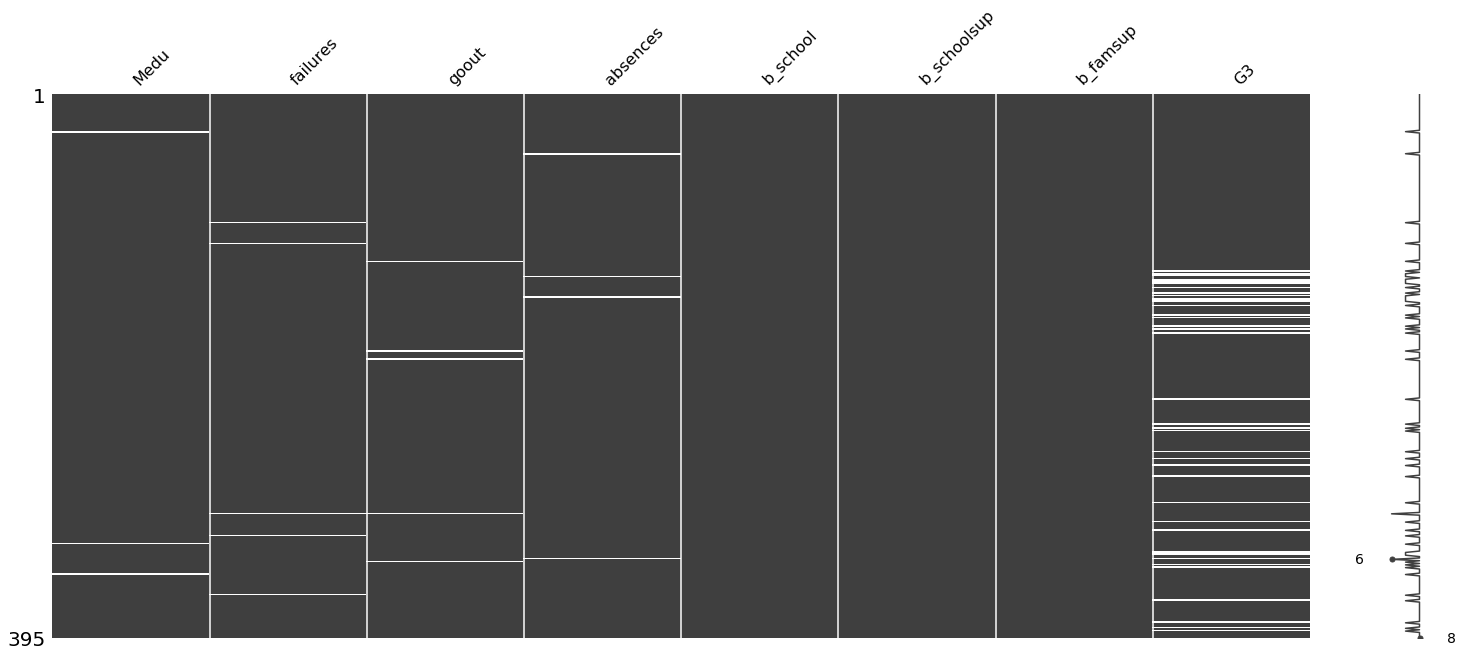

In [81]:
missingno.matrix(df_predict)

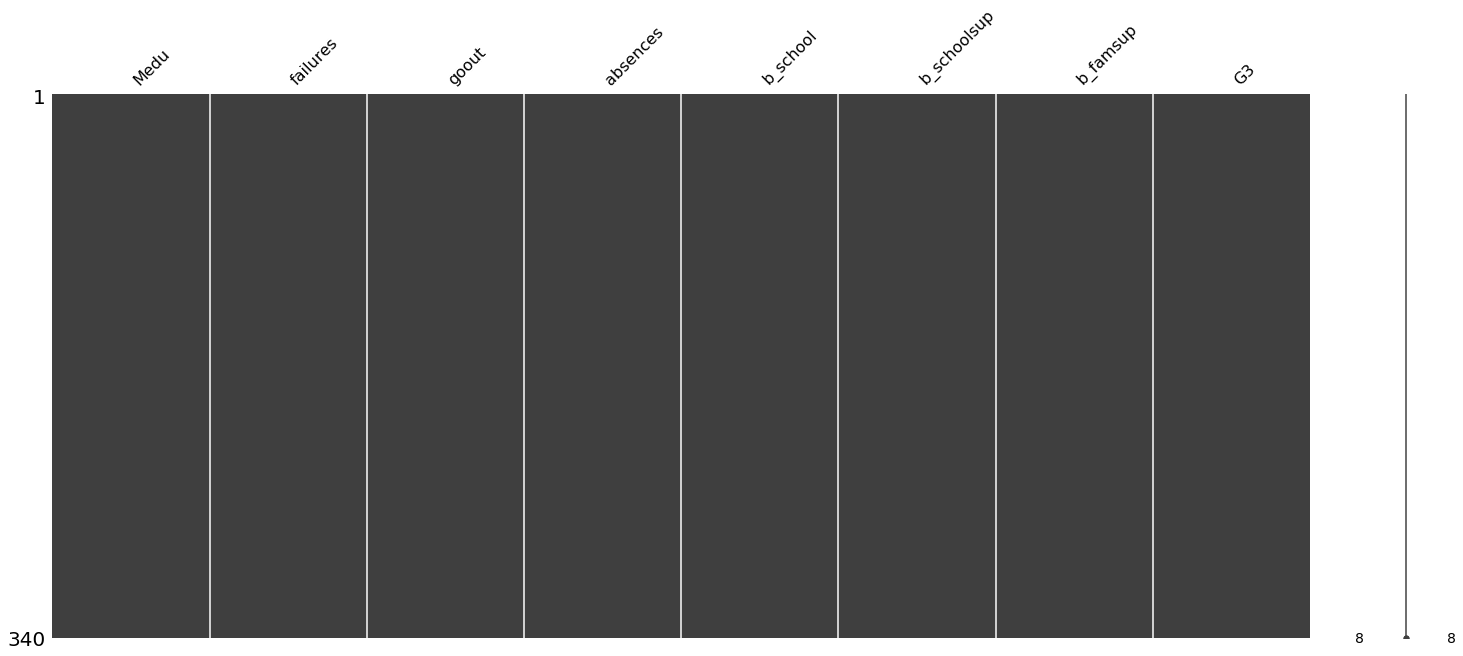

In [82]:
#como el dataframe actual no pierde tanta información al eliminar los datos nulos, se eliminaran todos los datos nulos
df_predict = df_predict.dropna()
missingno.matrix(df_predict)

In [83]:
#Separamos la variable dependiente 'G3' de la muestra de entrenamiento.
df_m = df_predict.drop(['G3'], axis = 1)
#Separamos la muestra de entrenamiento con la muestra de prueba.
#Muestra de entrenamiento.
x_mat_train = df_m[:-130]
#Muestra de prueba.
x_mat_test = df_m[-130:]

print('El tamaño de la muestra de entrenamiento es ', len(x_mat_train))
print('El tamaño de la muestra de prueba es ', len(x_mat_test))

El tamaño de la muestra de entrenamiento es  210
El tamaño de la muestra de prueba es  130


In [84]:
#Repetimos el proceso anterior con la muestra de la variable independiente 'G3'.
#Muestra de entrenamiento.
y_mat_train = df_predict['G3'][:-130]
#Muestra de prueba.
y_mat_test = df_predict['G3'][-130:]

print('El tamaño de la muestra de entrenamiento es ', len(y_mat_train))
print('El tamaño de la muestra de prueba es ', len(y_mat_test))

El tamaño de la muestra de entrenamiento es  210
El tamaño de la muestra de prueba es  130


In [85]:
#Ahora utilizamos el método de regresion lineal e instanciamos el modelo
sklearn_regresion = linear_model.LinearRegression(fit_intercept=True, normalize=False)
sklearn_regresion.fit(x_mat_train, y_mat_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [86]:
# imprimimos la lista de coeficientes
print("La lista de pendientes: :", sklearn_regresion.coef_)
# imprimimos el intercepto del modelo
print("El intercepto del modelo es :", sklearn_regresion.intercept_)

La lista de pendientes: : [ 0.74661252 -0.92551274 -0.58705469 -0.0944871  -0.59246612 -1.53439464
  1.11938368]
El intercepto del modelo es : 11.864845622486229


In [87]:
#Generamos las predicciones con predict()
g3_yhat = modelo.predict(x_mat_test)
print("La cantidad de predicciones realizadas en X_mat_test son: ", len(g3_yhat))
print("las predicciones son ", g3_yhat)

La cantidad de predicciones realizadas en X_mat_test son:  130
las predicciones son  240    11.504473
241    12.691084
243    14.077371
245    12.090461
246    12.756947
247     7.723196
248    10.703798
249    12.009963
250    10.950784
251    10.489350
252    10.147213
253    13.043667
254    13.043667
255     9.577047
256    12.404365
257    13.020538
258    11.423975
260    11.852293
261    13.214211
262    13.488839
263    12.750673
265    10.339500
266    12.370906
267    12.457679
268    11.071392
270     8.115431
271    10.467767
272    11.140528
273    11.663655
274    11.657380
         ...    
360    11.480562
361    10.819974
362    12.840719
364    12.526815
365    10.474042
366    14.077371
368    11.800740
369    12.640772
370    11.193090
371    11.068848
372    11.947101
373     9.953917
374    13.031118
375    12.383455
376    10.467015
377    13.267525
378    13.037392
379    10.575907
380    12.744398
381    12.162141
382    12.377180
384    11.510371
385    12.3771

**Generamos metricas para evaluar el modelo, las que utilizaremos son: $R²$ y 'Mean square error' (mse)**

In [88]:
m1_reg_mse = mean_squared_error(y_mat_test, g3_yhat).round(1)
m1_reg_r2 = r2_score(y_mat_test, g3_yhat).round(2)
print("Mean Squared Error: ", m1_reg_mse)
print("R-cuadrado: ", m1_reg_r2)

Mean Squared Error:  8.2
R-cuadrado:  0.1


* Este modelo tiene un error cuadratico muy bajo, lo que es bueno ya que tiene mejores niveles de ajuste, pero tiene un $R²$ muy bajo en comparación con el modelo anterior, por lo que la capacidad explicativa de la variable dependiente es menor que en el modelo de regresión lineal que se realizo previamente.